In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import time

In [2]:
from custom_pyro_shocktube import CustomPyro
from custom_pysph_shocktube import CustomShockTube2D
from mesh.patch import CellCenterData2d
from mesh.boundary import BC

In [3]:
class Hybrid_sim():
    solver = "compressible"
    problem_name = "sod"
    param_file = "inputs.sod.x"
    other_commands = ["driver.max_steps=24000","driver.tmax=0.05","driver.tmax=0.012","vis.dovis=0",
                      "mesh.nx=500","mesh.ny=25","mesh.ymax=0.05",
                      "sod.p_left=1000.0","sod.p_right=0.01","sod.dens_left=1.0","sod.dens_right=1.0"]
    
    def initialize_pyro(self):
        self.pyro_sim = CustomPyro(self.solver)
        self.pyro_sim.initialize_problem(self.problem_name,self.param_file,
                                         other_commands=self.other_commands)
        
    def initialize_pysph(self):
        self.pysph_sim = CustomShockTube2D()
        self.pysph_sim.setup()
        self.pysph_sim.particles[0].add_property(name='particle_type_id',type='double',default=2.0)
        self.pysph_sim.particles[0].add_property(name='id',type='int',default=-1)
        
    def initialize_particle_map(self,shrink_factor):
        """ Initializes the SPH particle population map based on the underlying Pyro grid and shrink factor.
        Stores the resulting ArrayIndexer object under self.injection_map.
        Args:
            self
            shrink_factor (int): factor to shrink SPH map relative to Pyro grid. Must be a factor of 2.
        Returns:
            None
        """
        assert np.log2(shrink_factor).is_integer(), "shrink_factor must be a factor of 2."
        
        new_grid = hybrid_sim.pyro_sim.sim.cc_data.grid.fine_like(shrink_factor)
        self.injection_map = CellCenterData2d(new_grid)
        self.injection_map.shrink_factor = shrink_factor
        self.injection_map.grid = new_grid
        # Boundaries not used, creating outflow boundaries just in case
        bc = BC(xlb="outflow", xrb="outflow",ylb="outflow", yrb="outflow")
        self.injection_map.register_var("particle_map",bc)
        self.injection_map.register_var("gradient_flag_mirror",bc)
        self.injection_map.register_var("gradient_flag_old",bc)
        #self.injection_map.register_var("particle_map_old",bc)
        #self.injection_map.register_var("difference_map",bc)
        self.injection_map.create()
        self.injection_map.data[:,:,0] = 1.0
        
    def extend_flag_to_particle_map(self):
        """ Projects the pyro gradient_final array to self.injection_map.data[:,:,1] (particle_flag_mirror)
        Args:
            self
        Returns:
            None
        """
        # Set gradient_flag_old to current gradient_flag_mirror
        self.injection_map.data[:,:,2] = self.injection_map.data[:,:,1]
        self.injection_map.zero("gradient_flag_mirror")
        # Compute new gradient_flag_mirror
        ghosts = self.pyro_sim.sim.cc_data.grid.ng
        shrink = self.injection_map.shrink_factor
        for i in range(shrink):
            for j in range(shrink):
                self.injection_map.data[ghosts+i:-ghosts:shrink,ghosts+j:-ghosts:shrink,1] += self.pyro_sim.sim.cc_data.gradient_final[ghosts:-ghosts,ghosts:-ghosts]
        
    def update_particle_map(self):
        """ Calculates the difference between gradient_flag_mirror and gradient_flag_old to update particle_map
        Args:
            self
        Returns:
            None
        """
        # Returns a particle_flag value of 1 when gradient_flag goes from 0 to 1 (new SPH boundary region)
        binary_flag_mirror = np.where(self.injection_map.data[:,:,1]>0,1,0)
        difference = binary_flag_mirror - self.injection_map.data[:,:,2]
        self.injection_map.data[:,:,0] = np.where(difference==1,1,0)
        
    def inject_particles(self):
        """ Injects new SPH particles in regions where the injection map is equal to 1.
        Args:
            None
        Returns:
            None
        """
        grid = self.injection_map.grid
        x_vals = np.extract(self.injection_map.data[:,:,0]>0,grid.x2d)
        y_vals = np.extract(self.injection_map.data[:,:,0]>0,grid.y2d)
        self.pysph_sim.add_particles([x_vals,y_vals])
        
    def flag_pysph_particles(self):
        """ Flags pysph particles based on value of pyro_sim.sim.cc_data.gradient_final at each cell. 
            Particle values (2, 1, or 0) reflect gradient_final values corresponding to active, boundary,
            or void (marked for deletion) particles.
        Args:
            self
        Returns:
            None
        """
        x_bins = np.digitize(self.pysph_sim.particles[0].x, self.pyro_sim.sim.cc_data.grid.x)
        y_bins = np.digitize(self.pysph_sim.particles[0].y, self.pyro_sim.sim.cc_data.grid.y)
        self.pysph_sim.particles[0].particle_type_id = self.pyro_sim.sim.cc_data.gradient_final[x_bins,y_bins]
        
    def pyro_to_pysph(self,mode=None):
        """ Transfers pyro primitive variables to pysph particles via 2d linear interpolation
        Args:
            self: Must run self.pysph_sim.particle_sort() prior to initialize/set value: id
            mode (str): 'all'; extrapolate values to all pysph particles
                        None (default); extrapolate only to pysph particles marked as boundaries
        Returns:
            None
        """
        # Note: Using extract_particles creates a new array, increasing function time from ~2ms to ~10ms min.
        if (mode == 'all'):
            extracted_ids = self.pysph_sim.particles[0].id
        else:
            extracted_ids = np.extract(self.pysph_sim.particles[0].particle_type_id == 1,self.pysph_sim.particles[0].id)
        particles_x = self.pysph_sim.particles[0].x[extracted_ids]
        particles_y = self.pysph_sim.particles[0].y[extracted_ids]
        
        x_bins = np.digitize(particles_x, self.pyro_sim.sim.cc_data.grid.x)
        y_bins = np.digitize(particles_y, self.pyro_sim.sim.cc_data.grid.y)
        
        inv_dx = 1/self.pyro_sim.sim.cc_data.grid.dx
        inv_dy = 1/self.pyro_sim.sim.cc_data.grid.dy
        
        x_1_i = (self.pyro_sim.sim.cc_data.grid.x[x_bins] - particles_x)*inv_dx
        x_i_0 = (particles_x - self.pyro_sim.sim.cc_data.grid.x[x_bins-1])*inv_dx
        y_1_i = (self.pyro_sim.sim.cc_data.grid.y[y_bins] - particles_y)*inv_dy
        y_i_0 = (particles_y - self.pyro_sim.sim.cc_data.grid.y[y_bins-1])*inv_dy
        
        self.pysph_sim.particles[0].rho[extracted_ids] = (x_1_i*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins-1,0]
                                                 + x_i_0*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins,y_bins-1,0]
                                                 + x_1_i*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,0]
                                                 + x_i_0*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,0])
        self.pysph_sim.particles[0].u[extracted_ids] = (x_1_i*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins-1,1]
                                                 + x_i_0*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins,y_bins-1,1]
                                                 + x_1_i*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,1]
                                                 + x_i_0*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,1])
        self.pysph_sim.particles[0].v[extracted_ids] = (x_1_i*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins-1,2]
                                                 + x_i_0*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins,y_bins-1,2]
                                                 + x_1_i*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,2]
                                                 + x_i_0*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,2])
        self.pysph_sim.particles[0].p[extracted_ids] = (x_1_i*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins-1,3]
                                                 + x_i_0*y_1_i*self.pyro_sim.sim.cc_data.prim_array[x_bins,y_bins-1,3]
                                                 + x_1_i*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,3]
                                                 + x_i_0*y_i_0*self.pyro_sim.sim.cc_data.prim_array[x_bins-1,y_bins,3])
      
    def pysph_to_pyro(self,mode=None):
        """ Transfers pysph field data to pyro primitive variables via 2d linear interpolation
        Args:
            self
            mode (str): 'all'; extrapolate values to all pysph particles
                        None (default); extrapolate only to pysph particles marked as boundaries
        Returns:
            None
        Note: Test a version combining w,rho,u,v,p and using higher dimensional np.histogramdd method
        """
        #indicies = np.extract(self.pyro_sim.sim.cc_data.gradient_final>1,)
        ghosts = self.pyro_sim.sim.cc_data.grid.ng
        ghosts1 = ghosts - 1
        
        x_bins = np.digitize(self.pysph_sim.particles[0].x, self.pyro_sim.sim.cc_data.grid.x)
        y_bins = np.digitize(self.pysph_sim.particles[0].y, self.pyro_sim.sim.cc_data.grid.y)

        inv_dx = 1/self.pyro_sim.sim.cc_data.grid.dx
        inv_dy = 1/self.pyro_sim.sim.cc_data.grid.dy

        x_1_i = (self.pyro_sim.sim.cc_data.grid.x[x_bins] - self.pysph_sim.particles[0].x)*inv_dx
        x_i_0 = (self.pysph_sim.particles[0].x - self.pyro_sim.sim.cc_data.grid.x[x_bins-1])*inv_dx
        y_1_i = (self.pyro_sim.sim.cc_data.grid.y[y_bins] - self.pysph_sim.particles[0].y)*inv_dy
        y_i_0 = (self.pysph_sim.particles[0].y - self.pyro_sim.sim.cc_data.grid.y[y_bins-1])*inv_dy

        w00 = x_1_i*y_1_i
        w01 = x_i_0*y_1_i
        w10 = x_1_i*y_i_0
        w11 = x_i_0*y_i_0
        w_rho00 = x_1_i*y_1_i*self.pysph_sim.particles[0].rho
        w_rho01 = x_i_0*y_1_i*self.pysph_sim.particles[0].rho
        w_rho10 = x_1_i*y_i_0*self.pysph_sim.particles[0].rho
        w_rho11 = x_i_0*y_i_0*self.pysph_sim.particles[0].rho
        w_u00 = x_1_i*y_1_i*self.pysph_sim.particles[0].u
        w_u01 = x_i_0*y_1_i*self.pysph_sim.particles[0].u
        w_u10 = x_1_i*y_i_0*self.pysph_sim.particles[0].u
        w_u11 = x_i_0*y_i_0*self.pysph_sim.particles[0].u
        w_v00 = x_1_i*y_1_i*self.pysph_sim.particles[0].v
        w_v01 = x_i_0*y_1_i*self.pysph_sim.particles[0].v
        w_v10 = x_1_i*y_i_0*self.pysph_sim.particles[0].v
        w_v11 = x_i_0*y_i_0*self.pysph_sim.particles[0].v
        w_p00 = x_1_i*y_1_i*self.pysph_sim.particles[0].p
        w_p01 = x_i_0*y_1_i*self.pysph_sim.particles[0].p
        w_p10 = x_1_i*y_i_0*self.pysph_sim.particles[0].p
        w_p11 = x_i_0*y_i_0*self.pysph_sim.particles[0].p
        
        xp = self.pysph_sim.particles[0].x
        yp = self.pysph_sim.particles[0].y
        x_cc = self.pyro_sim.sim.cc_data.grid.x
        y_cc = self.pyro_sim.sim.cc_data.grid.y
        
        hist_w_00 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w00)
        hist_w_01 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w01)
        hist_w_10 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w10)
        hist_w_11 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w11)
        hist_w_rho_00 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_rho00)
        hist_w_rho_01 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_rho01)
        hist_w_rho_10 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_rho10)
        hist_w_rho_11 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_rho11)
        hist_w_u_00 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_u00)
        hist_w_u_01 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_u01)
        hist_w_u_10 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_u10)
        hist_w_u_11 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_u11)
        hist_w_v_00 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_v00)
        hist_w_v_01 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_v01)
        hist_w_v_10 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_v10)
        hist_w_v_11 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_v11)
        hist_w_p_00 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_p00)
        hist_w_p_01 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_p01)
        hist_w_p_10 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_p10)
        hist_w_p_11 = np.histogram2d(x=xp,y=yp,bins=[x_cc,y_cc],weights=w_p11)
        
        hist_w = hist_w_00[0][1:,1:] + hist_w_01[0][:-1,1:] + hist_w_10[0][1:,:-1] + hist_w_11[0][:-1,:-1]
        hist_rho = hist_w_rho_00[0][1:,1:] + hist_w_rho_01[0][:-1,1:] + hist_w_rho_10[0][1:,:-1] + hist_w_rho_11[0][:-1,:-1]
        hist_u = hist_w_u_00[0][1:,1:] + hist_w_u_01[0][:-1,1:] + hist_w_u_10[0][1:,:-1] + hist_w_u_11[0][:-1,:-1]
        hist_v = hist_w_v_00[0][1:,1:] + hist_w_v_01[0][:-1,1:] + hist_w_v_10[0][1:,:-1] + hist_w_v_11[0][:-1,:-1]
        hist_p = hist_w_p_00[0][1:,1:] + hist_w_p_01[0][:-1,1:] + hist_w_p_10[0][1:,:-1] + hist_w_p_11[0][:-1,:-1]
        rho = hist_rho[ghosts1:-ghosts1,ghosts1:-ghosts1]/hist_w[ghosts1:-ghosts1,ghosts1:-ghosts1]
        u = hist_u[ghosts1:-ghosts1,ghosts1:-ghosts1]/hist_w[ghosts1:-ghosts1,ghosts1:-ghosts1]
        v = hist_v[ghosts1:-ghosts1,ghosts1:-ghosts1]/hist_w[ghosts1:-ghosts1,ghosts1:-ghosts1]
        p = hist_p[ghosts1:-ghosts1,ghosts1:-ghosts1]/hist_w[ghosts1:-ghosts1,ghosts1:-ghosts1]
        
        if (mode == 'all'):
            rho_sub = rho
            u_sub = u
            v_sub = v
            p_sub = p
        else:
            rho_sub = np.where(self.pyro_sim.sim.cc_data.gradient_final[ghosts:-ghosts,ghosts:-ghosts]>1,rho,self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,0])
            u_sub = np.where(self.pyro_sim.sim.cc_data.gradient_final[ghosts:-ghosts,ghosts:-ghosts]>1,u,self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,1])
            v_sub = np.where(self.pyro_sim.sim.cc_data.gradient_final[ghosts:-ghosts,ghosts:-ghosts]>1,v,self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,2])
            p_sub = np.where(self.pyro_sim.sim.cc_data.gradient_final[ghosts:-ghosts,ghosts:-ghosts]>1,p,self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,3])
        
        self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,0] = rho_sub
        self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,1] = u_sub
        self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,2] = v_sub
        self.pyro_sim.sim.cc_data.prim_array[ghosts:-ghosts,ghosts:-ghosts,3] = p_sub
        
    def plot_2D_scatter_map(self,injection_code = 1):
        """ Plots gradient flag extrapolated to the injection map
        Args:
            self
            injection_code (int): int corresponding to which injection_map.data values to plot
        Returns:
            None
        """
        x_vals = self.injection_map.grid.x2d
        y_vals = self.injection_map.grid.y2d
        flag_map = self.injection_map.data[:,:,injection_code]

        fig, axs = plt.subplots(1,1,sharex=True)

        my_plot0 = axs.scatter(x_vals, y_vals, c=flag_map, cmap='coolwarm')
        axs.set_aspect('equal')
        axs.set_title('Injection Map')
        axs.set_xlim([0,1])
        axs.set_ylim([0,0.05])
        plt.show()


In [4]:
hybrid_sim = Hybrid_sim()
hybrid_sim.initialize_pyro()
hybrid_sim.initialize_pysph()
hybrid_sim.initialize_particle_map(2) # 2

pyro ...
initializing the sod problem...
cc data: nx = 500, ny = 25, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000000000    max:    1.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-even +y: reflect-even
          energy: min:    0.0250000000    max: 2500.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-even +y: reflect-even
      x-momentum: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-even +y: reflect-even
      y-momentum: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-odd  +y: reflect-odd 

Cubic packing domain: xmin, xmax, ymin, ymax =   0.0 1 0 0.05
Cubic packing particles: xmin, xmax, ymin, ymax =  0.001 0.999 0.001 0.049
Particle spacings: dx, dy =  0.002 0.002
Offset: xmin, xmax =  0.001 0.0010000000000000009
Offset: ymin, ymax =  0.001 0.0010000000

In [5]:
# manual deletion of all particles
hybrid_sim.pysph_sim.particles[0].particle_type_id = np.zeros(len(hybrid_sim.pysph_sim.particles[0].x))
print(hybrid_sim.pysph_sim.particles[0].particle_type_id)
hybrid_sim.pysph_sim.remove_flagged_particles()
print(hybrid_sim.pysph_sim.particles[0].particle_type_id)

[0. 0. 0. ... 0. 0. 0.]
[]


In [ ]:
hybrid_sim.pyro_sim.primitive_update()
hybrid_sim.pyro_sim.compute_gradients()
hybrid_sim.pyro_sim.flag_gradients(threshold=[300,6000,6000,6000])
hybrid_sim.pyro_sim.pysph_zoning(8,8)

In [ ]:
hybrid_sim.extend_flag_to_particle_map()
hybrid_sim.update_particle_map()

In [ ]:
hybrid_sim.pyro_sim.plot_2D_scatter_flag()
hybrid_sim.plot_2D_scatter_map(0)

In [ ]:
print(len(hybrid_sim.injection_map.data[:,:,1]))

In [ ]:
ghosts = hybrid_sim.pyro_sim.sim.cc_data.grid.ng
x_coords = hybrid_sim.pyro_sim.sim.cc_data.grid.x[ghosts:-ghosts]
y_coords = hybrid_sim.pyro_sim.sim.cc_data.grid.y[ghosts:-ghosts]
xx, yy = np.meshgrid(x_coords,y_coords)
xx_flat = np.ravel(xx)
#print((xx_flat[:1000]))
yy_flat = np.ravel(yy)
#print((yy_flat[:1000]))
hybrid_sim.pysph_sim.add_particles([xx_flat,yy_flat])

In [ ]:
print(len(hybrid_sim.pysph_sim.particles[0].x))

In [ ]:
print(hybrid_sim.pysph_sim.particles[0].y.min())
print(hybrid_sim.pysph_sim.particles[0].y.max())
print(hybrid_sim.pysph_sim.particles[0].x.min())
print(hybrid_sim.pysph_sim.particles[0].x.max())

In [ ]:
ordered_array = hybrid_sim.pysph_sim.particles[0].x[np.argsort(hybrid_sim.pysph_sim.particles[0].x)]
print(ordered_array[11500:])
#print(hybrid_sim.pysph_sim.particles[0].x)

In [ ]:
grid = hybrid_sim.injection_map.grid
x_vals = np.extract(hybrid_sim.injection_map.data[:,:,0]>0,grid.x2d)
y_vals = np.extract(hybrid_sim.injection_map.data[:,:,0]>0,grid.y2d)
print(x_vals)
print(y_vals)

<h3> Embedded Pyro Testing

In [ ]:
# For testing pysph first:
# Remember to apply conservative_update to pyro after interpolating values to primitive variables
hybrid_sim.pysph_to_pyro()
hybrid_sim.pyro_sim.conservative_update()

In [ ]:
# Try setting Pyro BCs
hybrid_sim.pyro_sim.sim.cc_data.fill_BC_all()

In [ ]:
hybrid_sim.pyro_sim.primitive_update()
hybrid_sim.pyro_sim.plot_2D_vertical([0,1000,-30,30,-5,5,0,8])

Finished step 0...
Finished step 1...
Finished step 2...
Finished step 3...
Finished step 4...
5


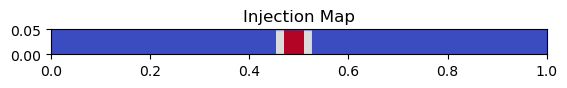

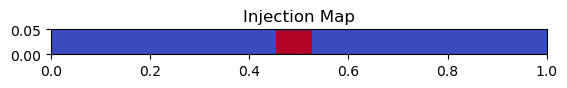

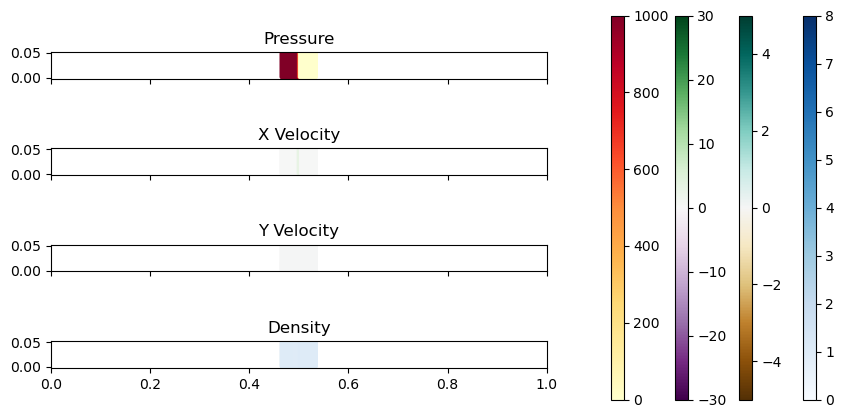

Finished step 5...
Finished step 6...
Finished step 7...
Finished step 8...
Finished step 9...


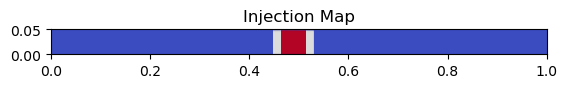

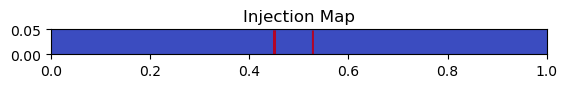

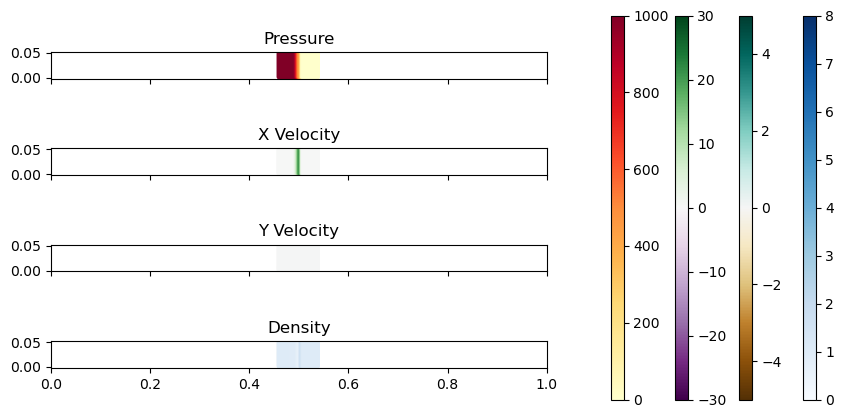

Finished step 10...
Finished step 11...
Finished step 12...
Finished step 13...
Finished step 14...


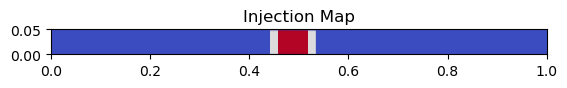

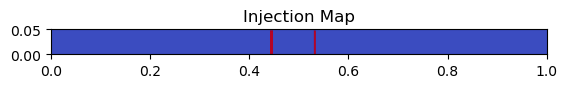

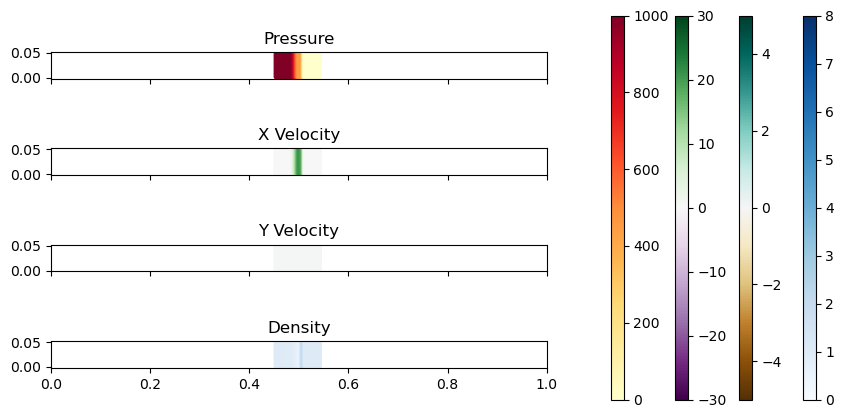

Finished step 15...
Finished step 16...
Finished step 17...
Finished step 18...
Finished step 19...


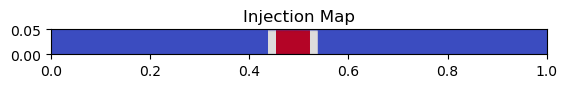

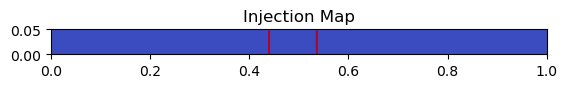

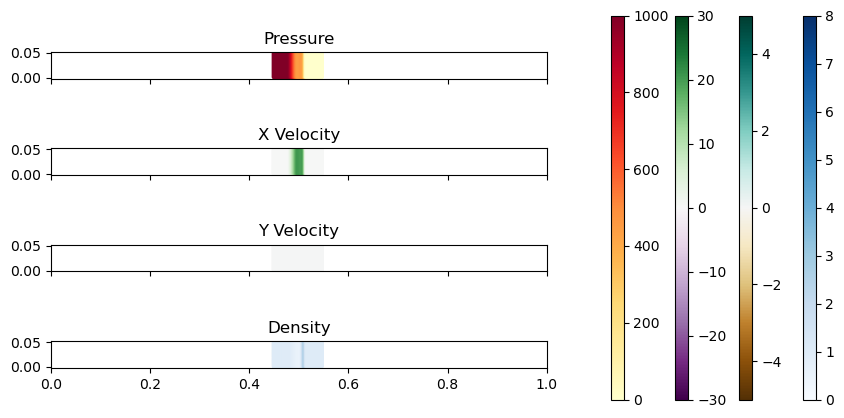

Finished step 20...
Finished step 21...
Finished step 22...
Finished step 23...
Finished step 24...


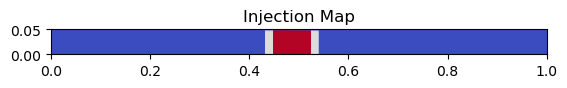

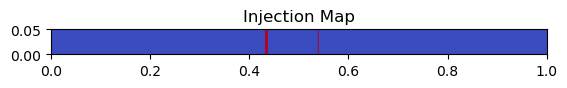

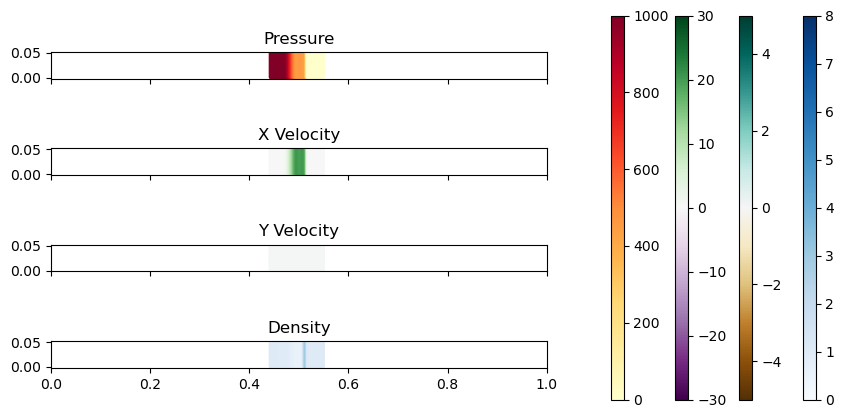

Finished step 25...
Finished step 26...
Finished step 27...
Finished step 28...
Finished step 29...


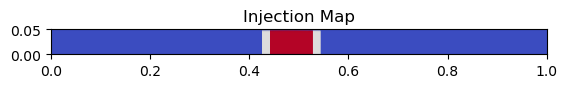

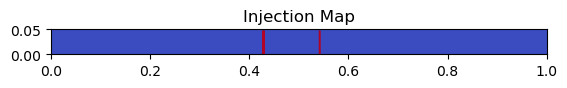

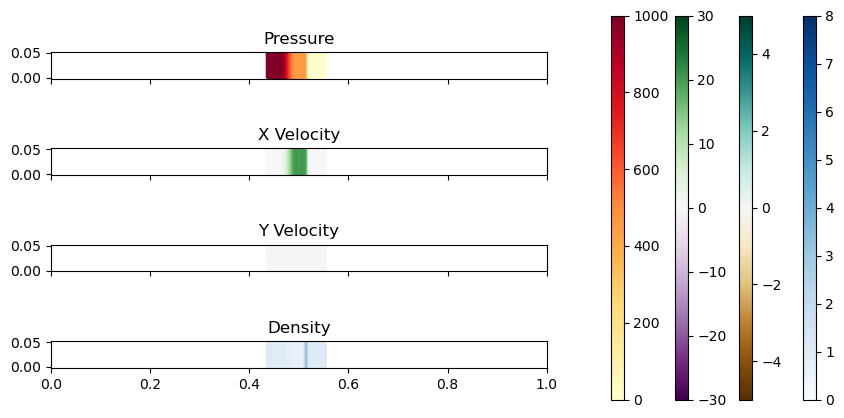

Finished step 30...
Finished step 31...
Finished step 32...
Finished step 33...
Finished step 34...


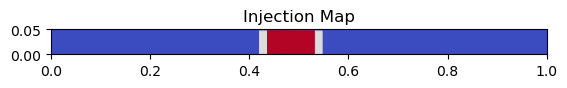

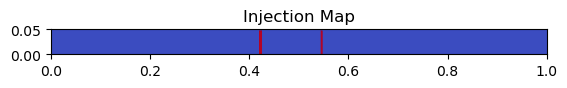

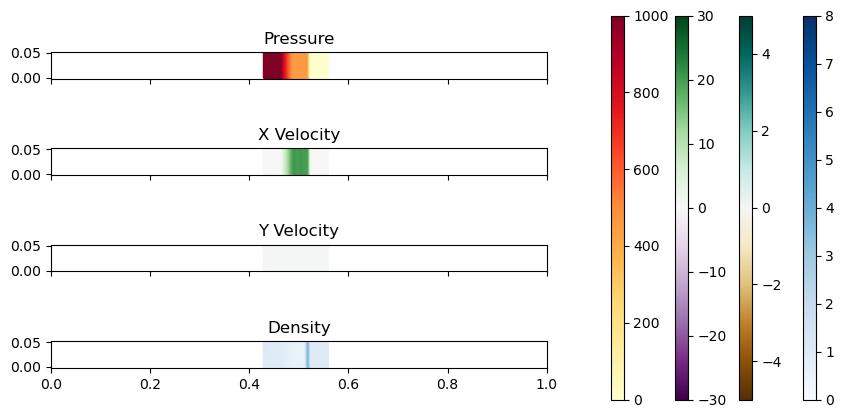

Finished step 35...
Finished step 36...
Finished step 37...
Finished step 38...
Finished step 39...


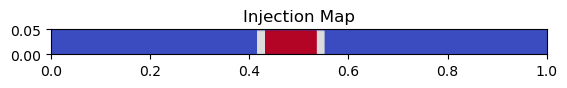

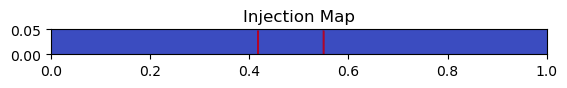

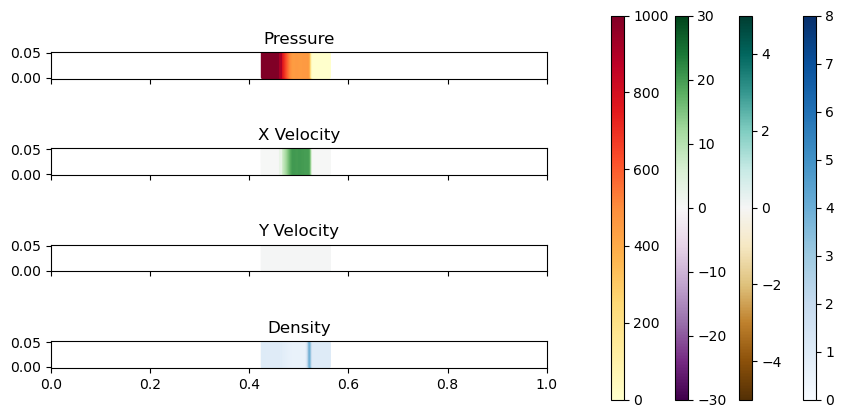

Finished step 40...
Finished step 41...
Finished step 42...
Finished step 43...
Finished step 44...


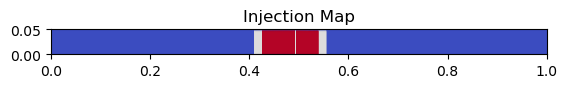

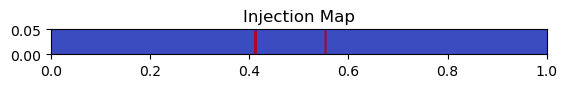

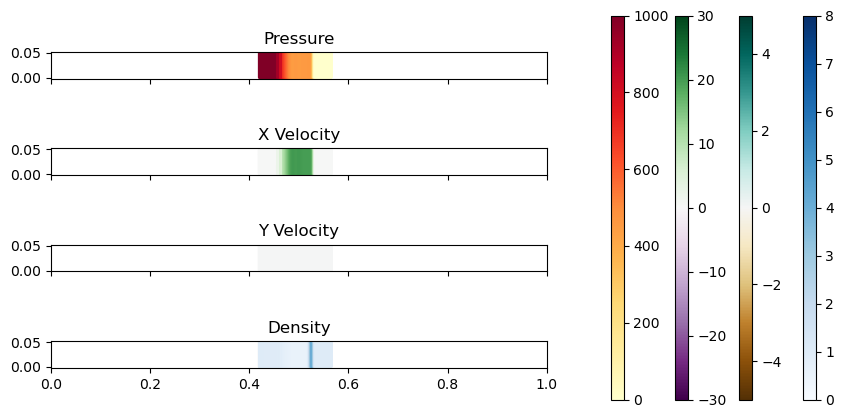

Finished step 45...
Finished step 46...
Finished step 47...
Finished step 48...
Finished step 49...


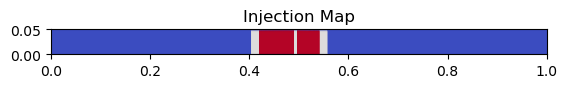

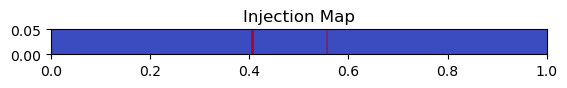

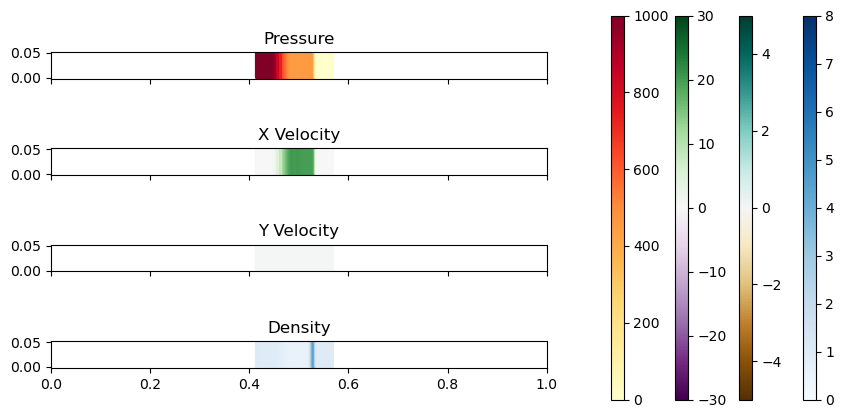

Finished step 50...
Finished step 51...
Finished step 52...
Finished step 53...
Finished step 54...


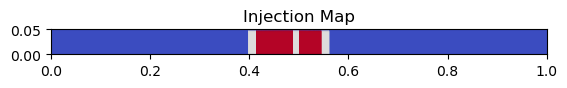

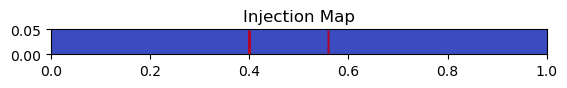

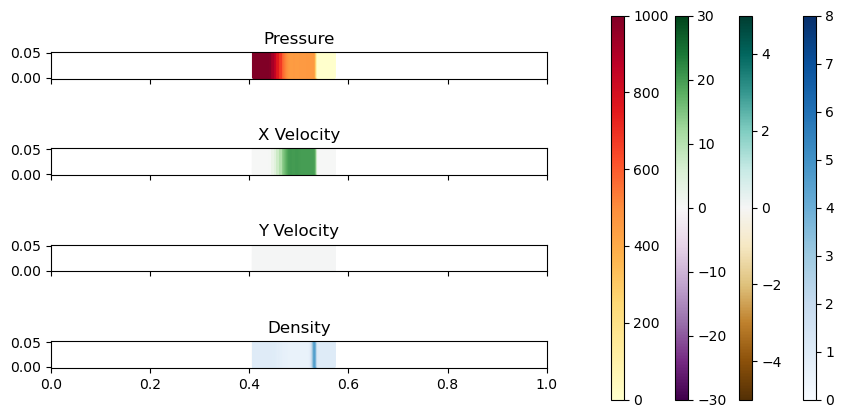

Finished step 55...
Finished step 56...
Finished step 57...
Finished step 58...
Finished step 59...


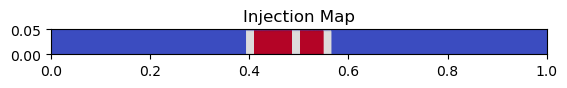

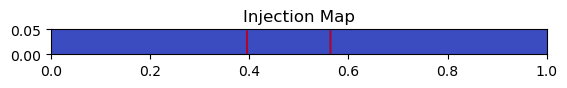

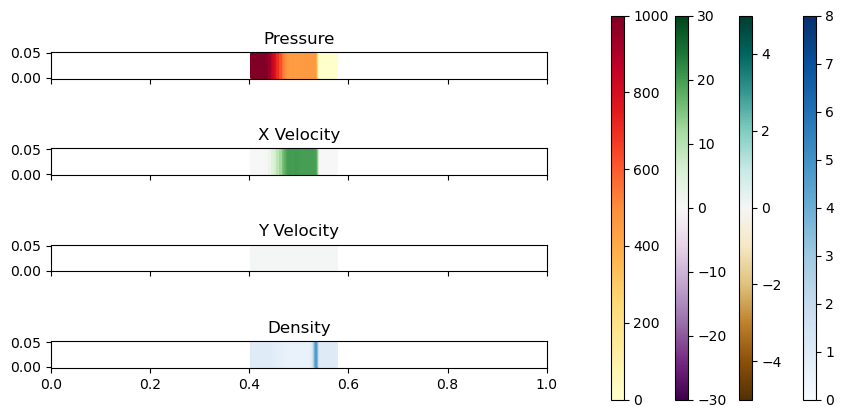

Finished step 60...
Finished step 61...
Finished step 62...
Finished step 63...
Finished step 64...


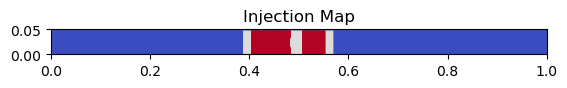

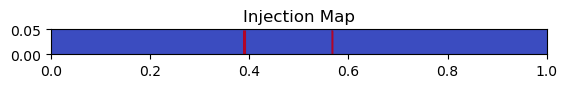

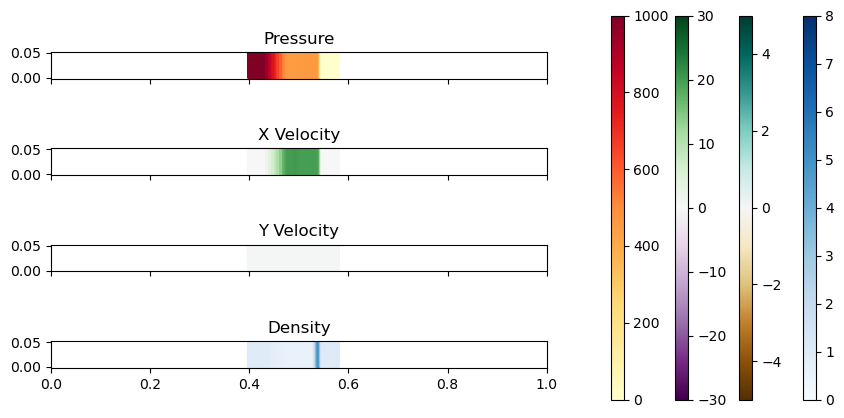

Finished step 65...
Finished step 66...
Finished step 67...
Finished step 68...
Finished step 69...


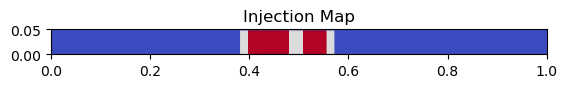

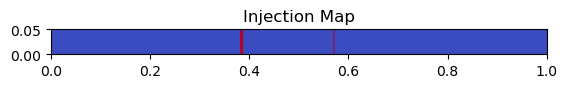

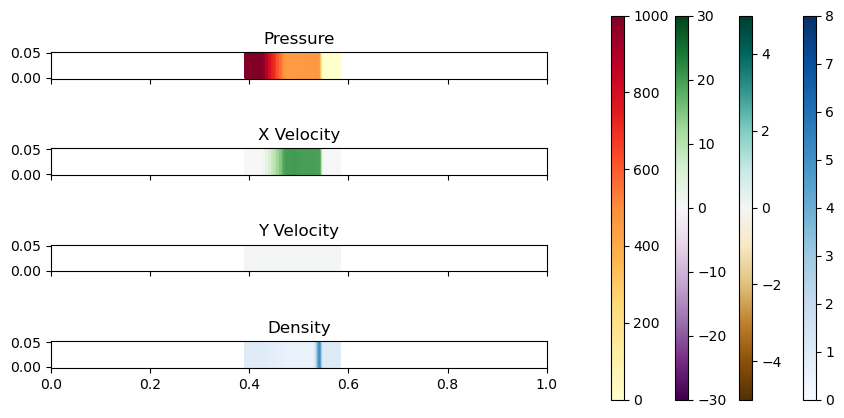

Finished step 70...
Finished step 71...
Finished step 72...
Finished step 73...
Finished step 74...


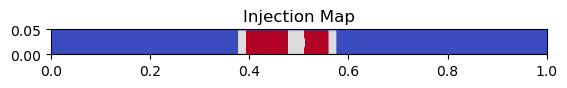

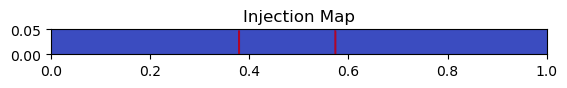

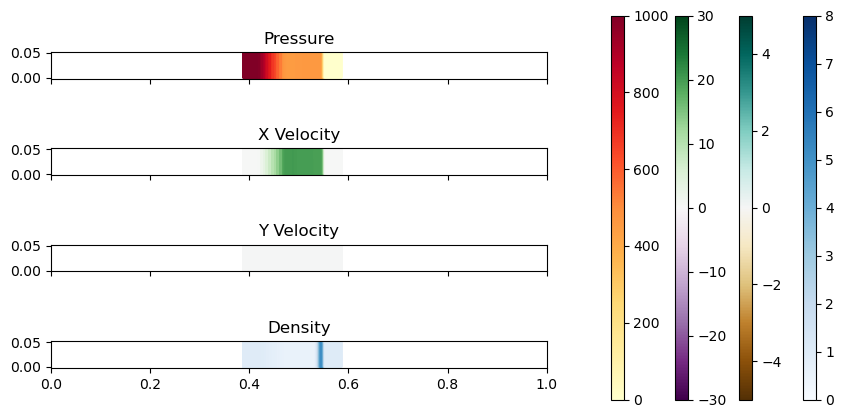

Finished step 75...
Finished step 76...
Finished step 77...
Finished step 78...
Finished step 79...


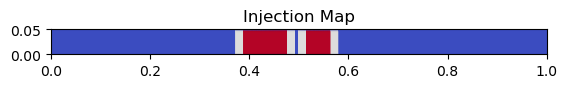

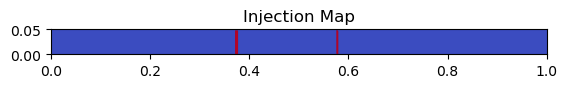

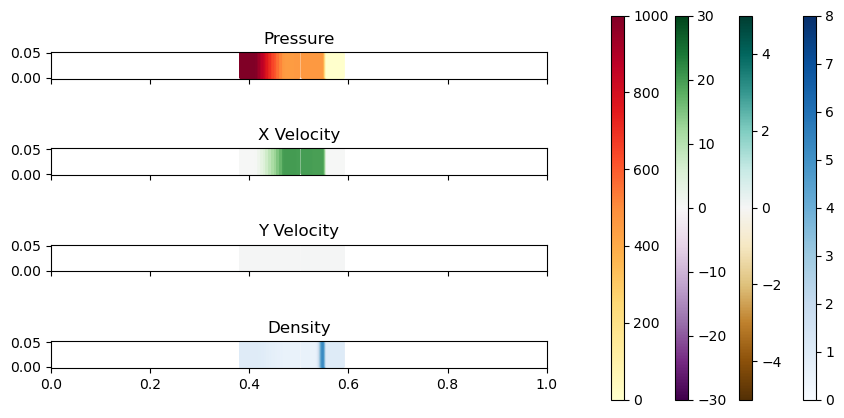

Finished step 80...
Finished step 81...
Finished step 82...
Finished step 83...
Finished step 84...


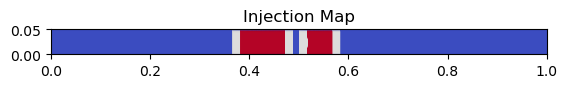

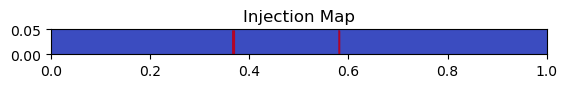

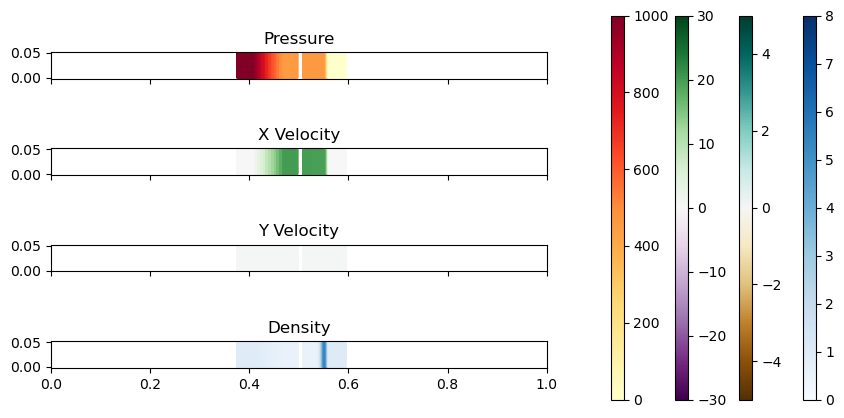

Finished step 85...
Finished step 86...
Finished step 87...
Finished step 88...
Finished step 89...


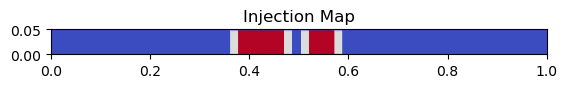

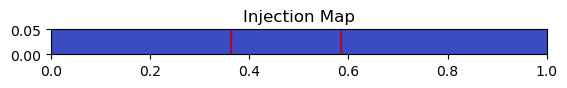

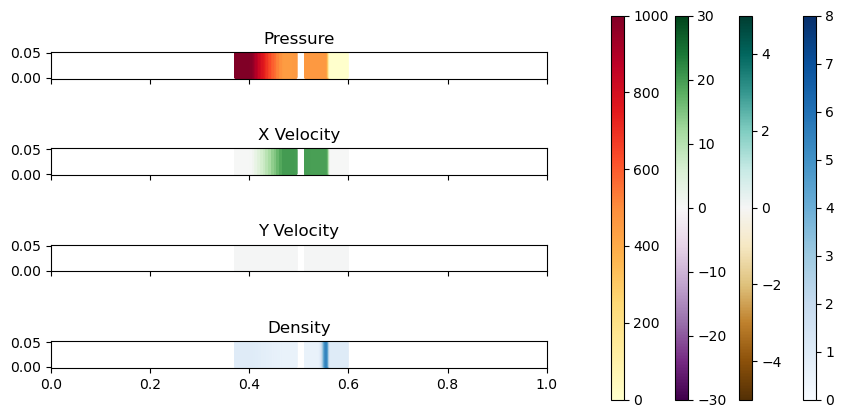

Finished step 90...
Finished step 91...
Finished step 92...
Finished step 93...
Finished step 94...


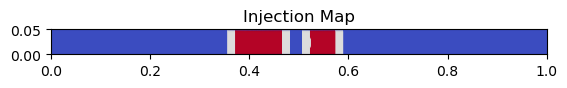

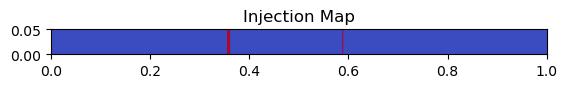

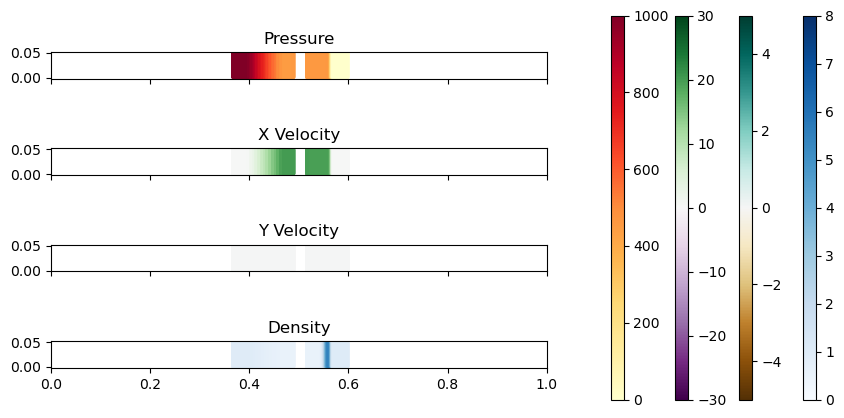

Finished step 95...
Finished step 96...
Finished step 97...
Finished step 98...
Finished step 99...


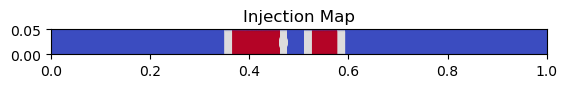

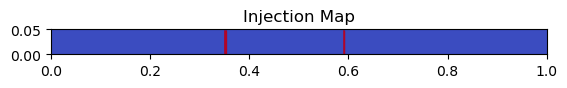

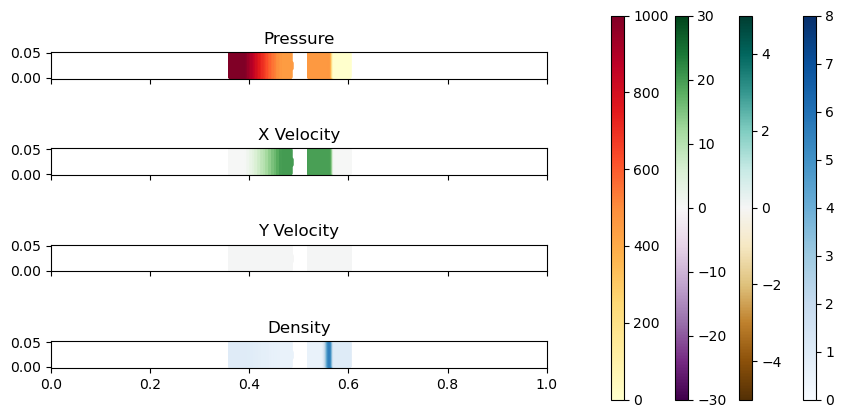

Finished step 100...
Finished step 101...
Finished step 102...
Finished step 103...
Finished step 104...


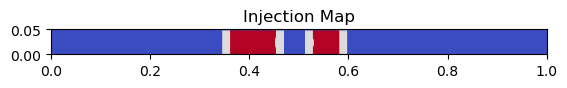

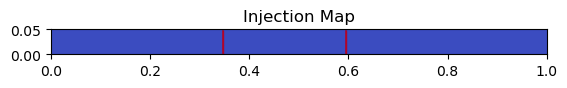

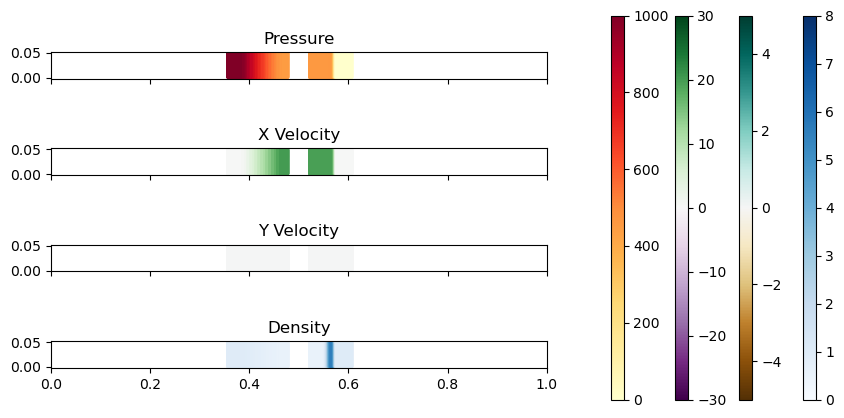

Finished step 105...
Finished step 106...
Finished step 107...
Finished step 108...
Finished step 109...


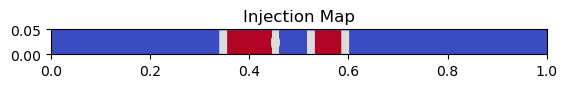

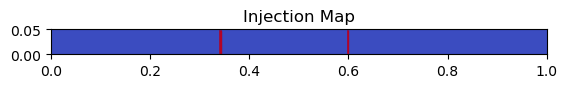

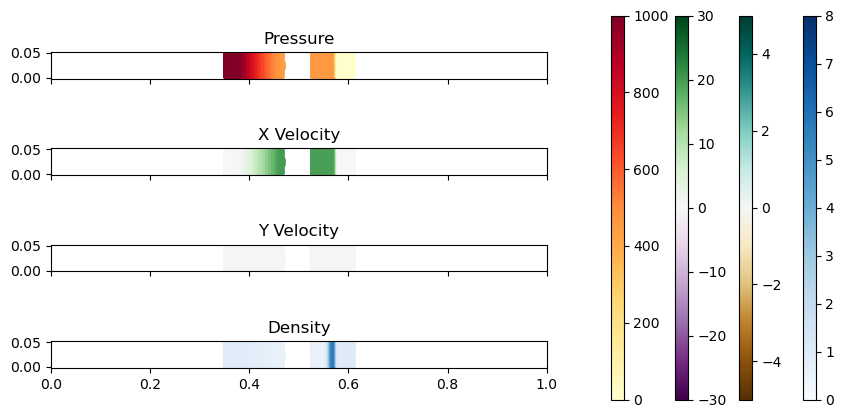

Finished step 110...
Finished step 111...
Finished step 112...
Finished step 113...
Finished step 114...


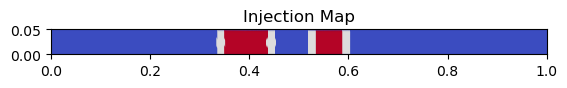

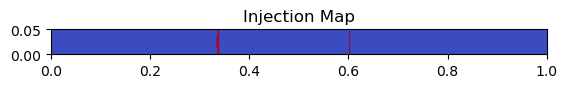

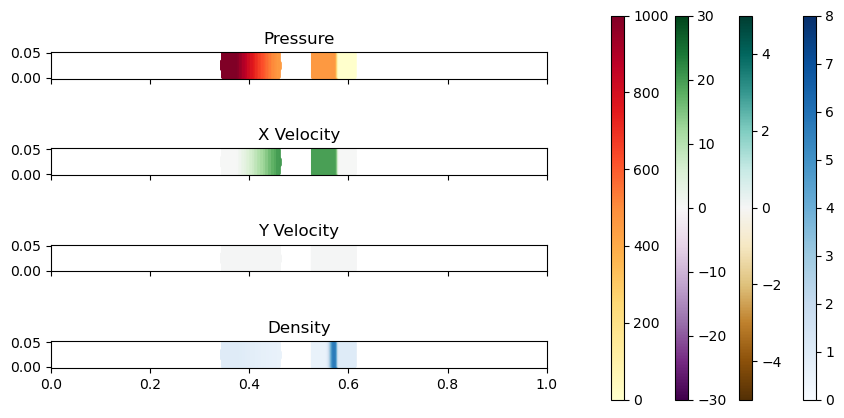

Finished step 115...
Finished step 116...
Finished step 117...
Finished step 118...
Finished step 119...


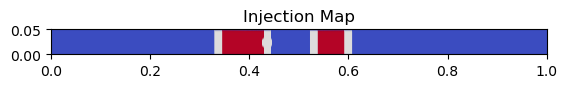

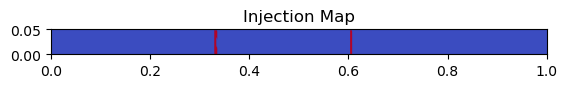

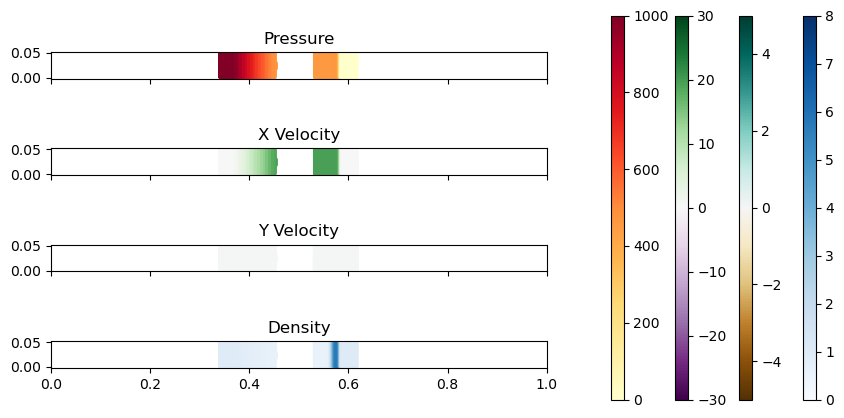

Finished step 120...
Finished step 121...
Finished step 122...
Finished step 123...
Finished step 124...


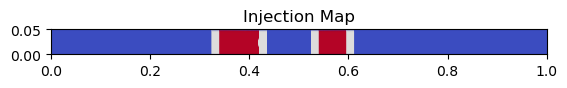

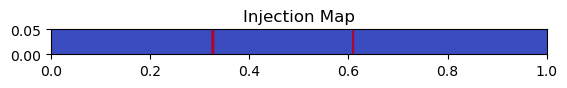

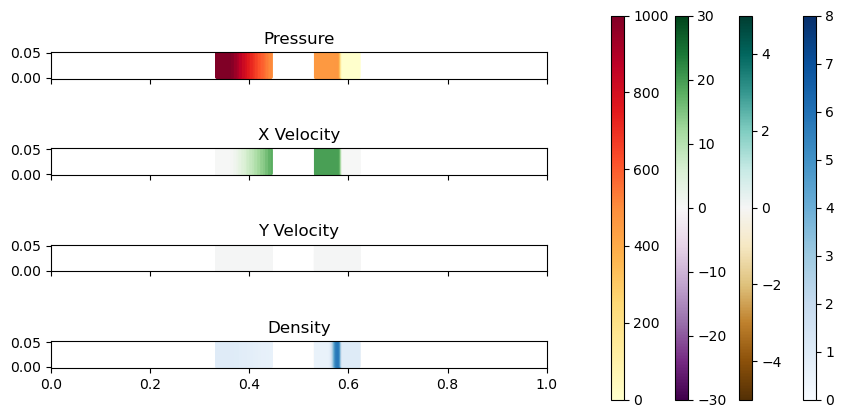

Finished step 125...
Finished step 126...
Finished step 127...
Finished step 128...
Finished step 129...


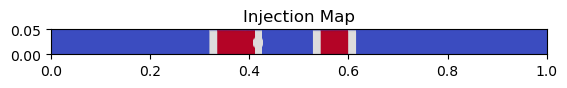

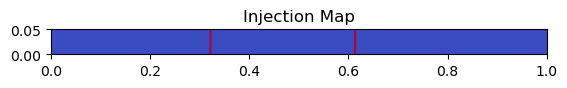

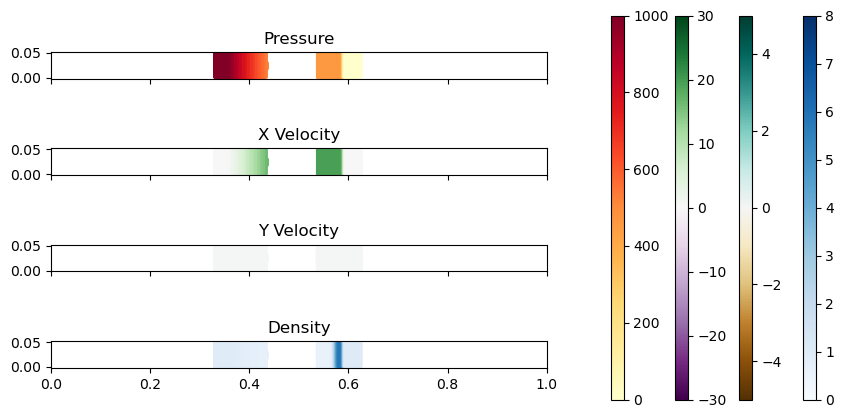

Finished step 130...
Finished step 131...
Finished step 132...
Finished step 133...
Finished step 134...


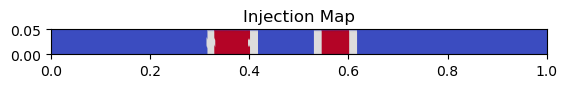

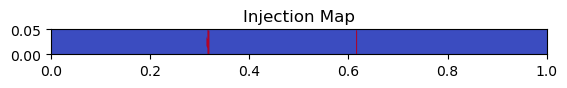

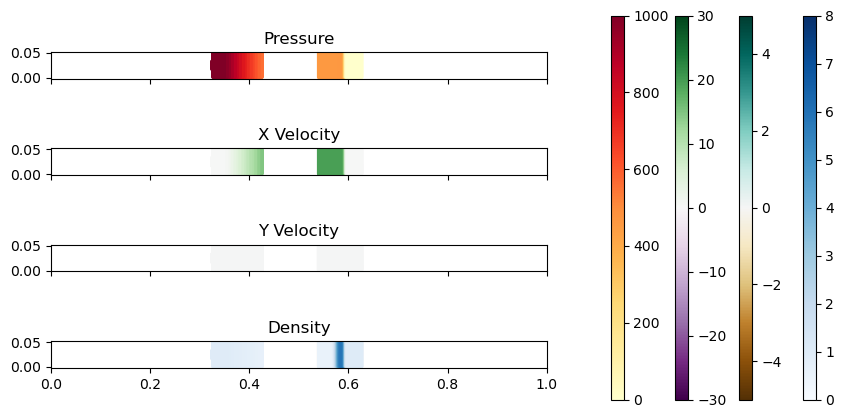

Finished step 135...
Finished step 136...
Finished step 137...
Finished step 138...
Finished step 139...


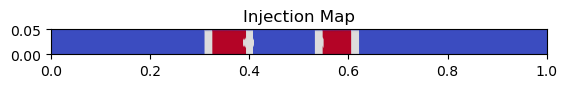

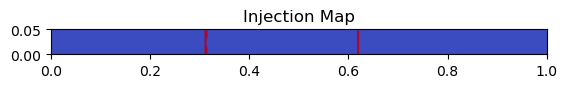

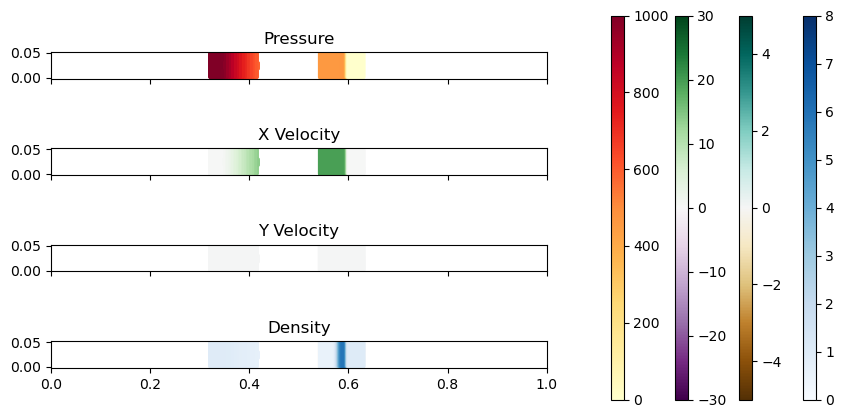

Finished step 140...
Finished step 141...
Finished step 142...
Finished step 143...
Finished step 144...


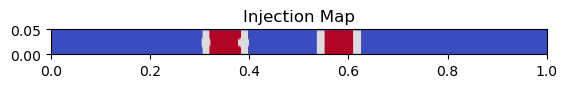

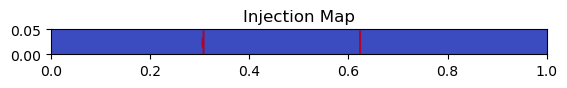

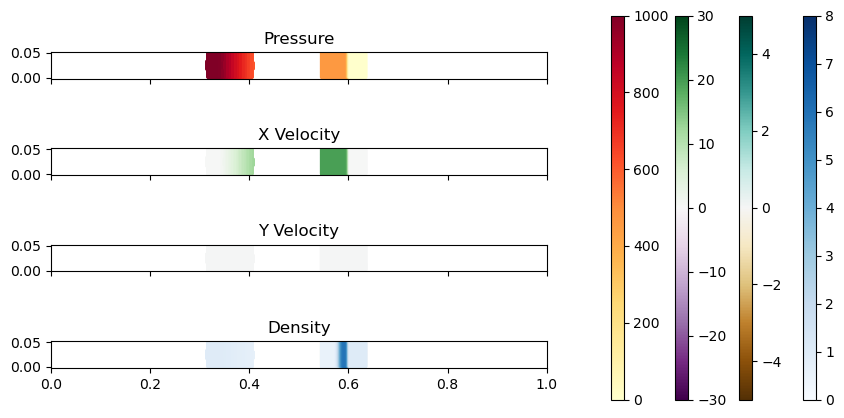

Finished step 145...
Finished step 146...
Finished step 147...
Finished step 148...
Finished step 149...


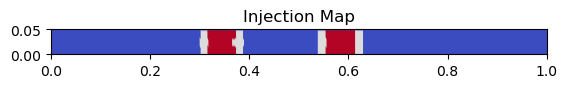

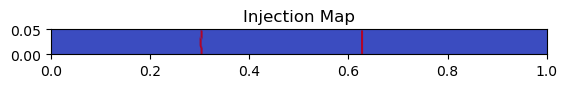

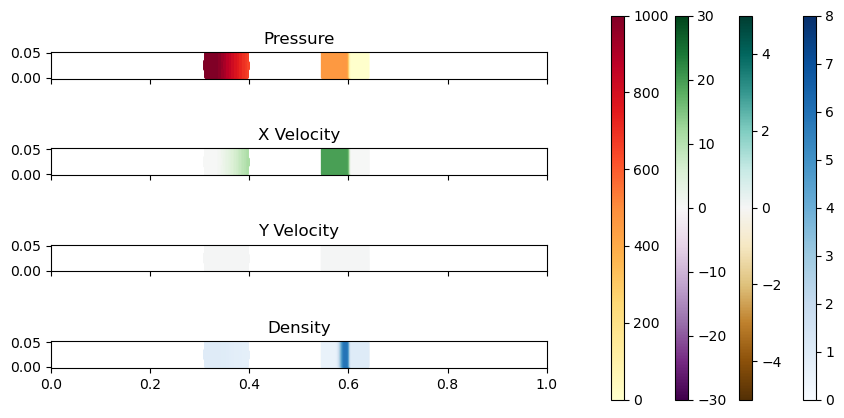

Finished step 150...
Finished step 151...
Finished step 152...
Finished step 153...
Finished step 154...


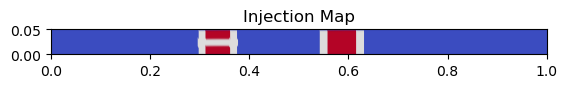

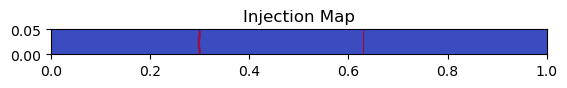

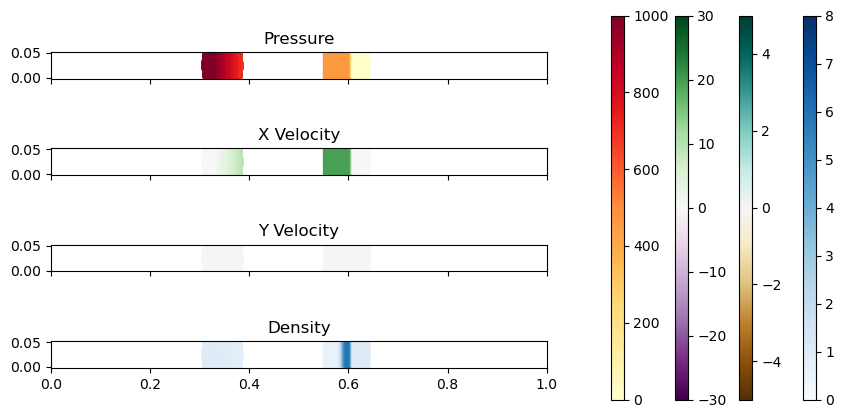

Finished step 155...
Finished step 156...
Finished step 157...
Finished step 158...
Finished step 159...


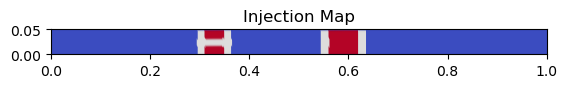

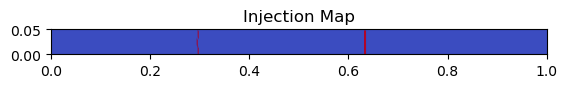

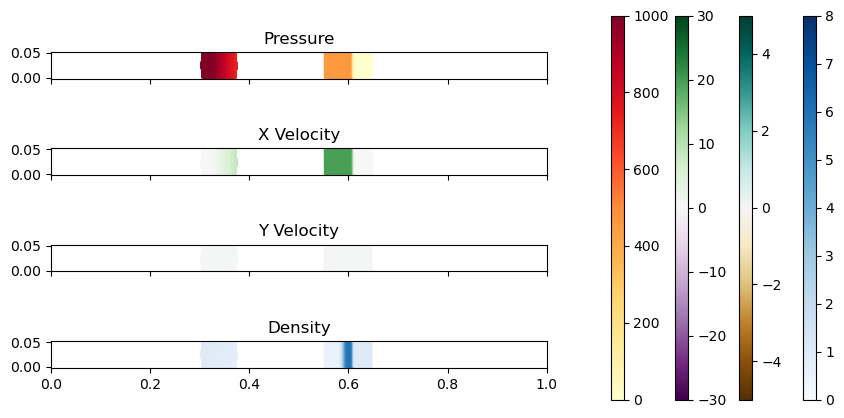

Finished step 160...
Finished step 161...
Finished step 162...
Finished step 163...
Finished step 164...


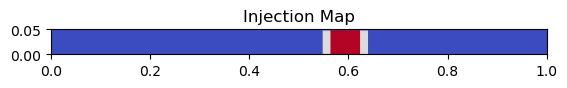

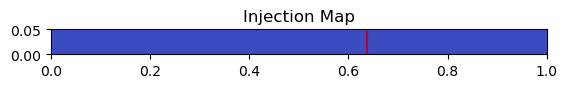

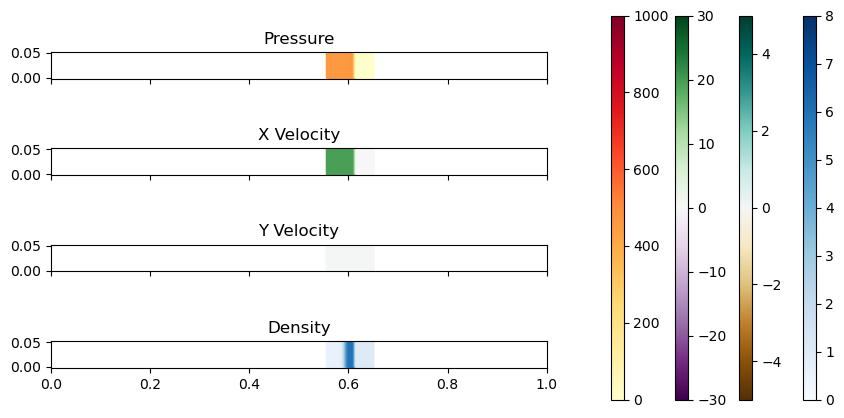

Finished step 165...
Finished step 166...
Finished step 167...
Finished step 168...
Finished step 169...


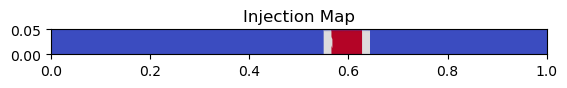

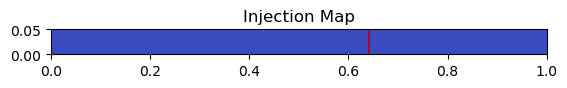

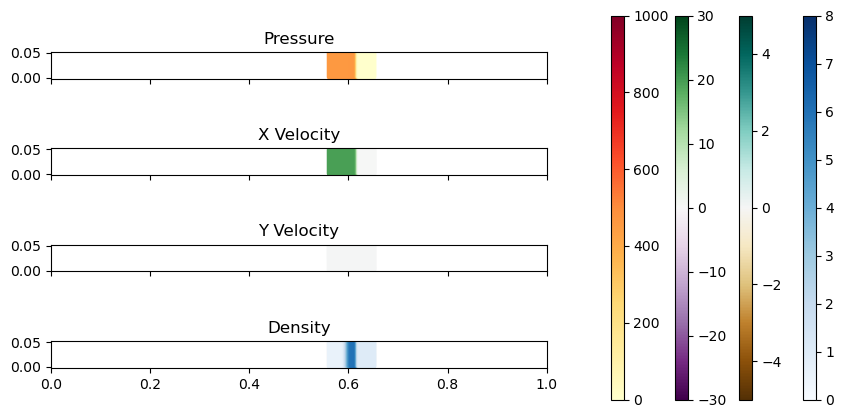

Finished step 170...
Finished step 171...
Finished step 172...
Finished step 173...
Finished step 174...


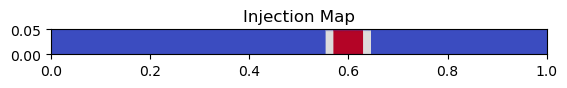

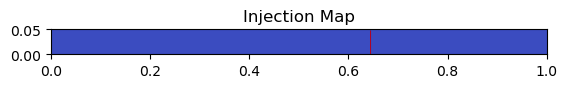

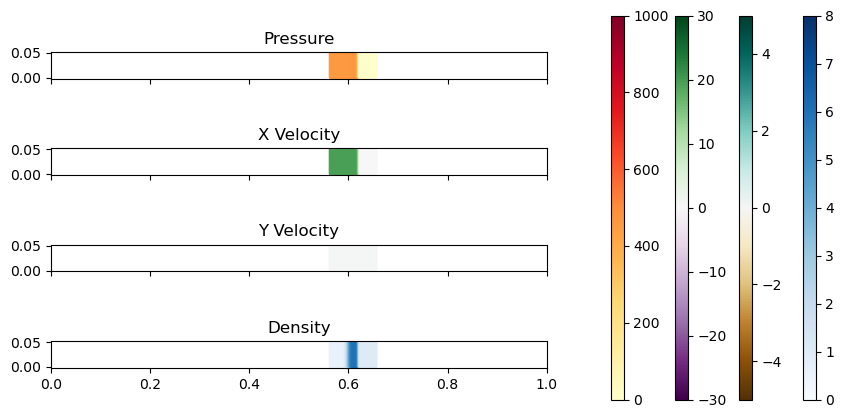

Finished step 175...
Finished step 176...
Finished step 177...
Finished step 178...
Finished step 179...


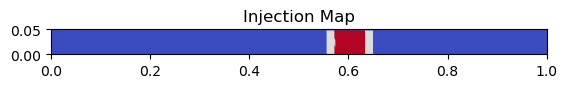

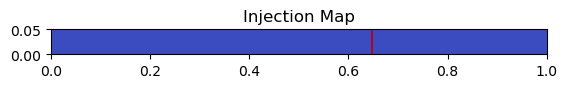

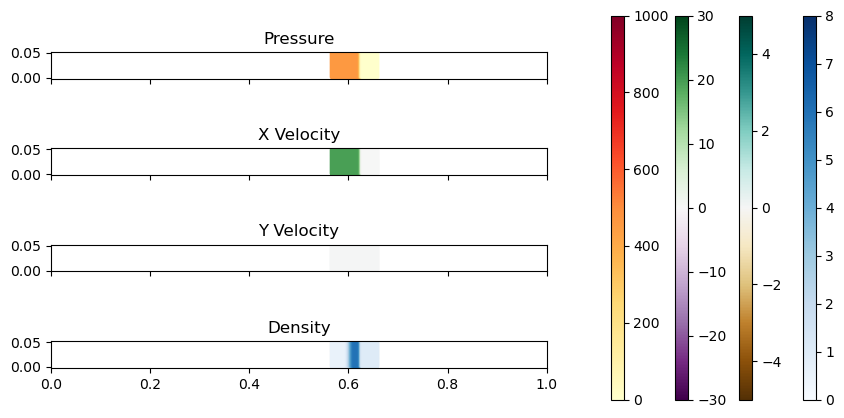

Finished step 180...
Finished step 181...
Finished step 182...
Finished step 183...
Finished step 184...


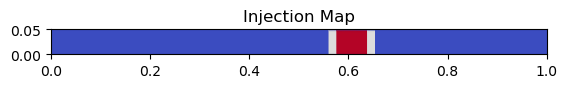

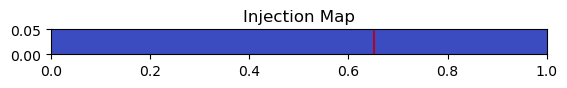

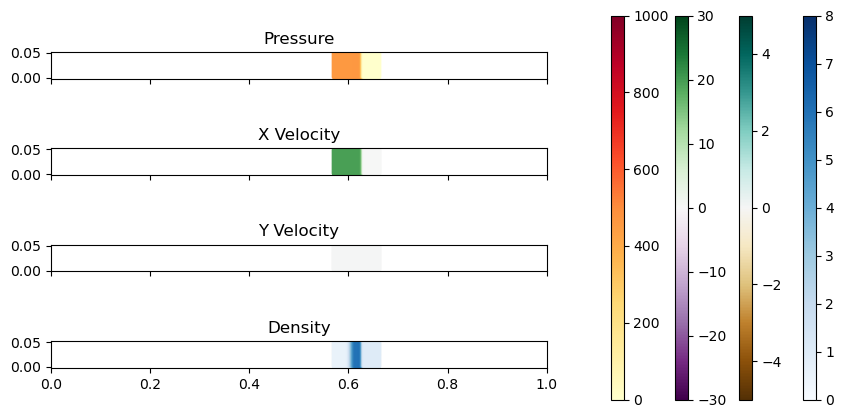

Finished step 185...
Finished step 186...
Finished step 187...
Finished step 188...
Finished step 189...


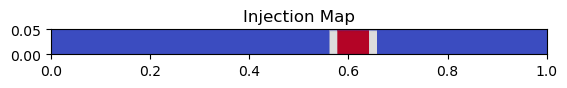

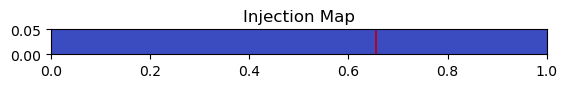

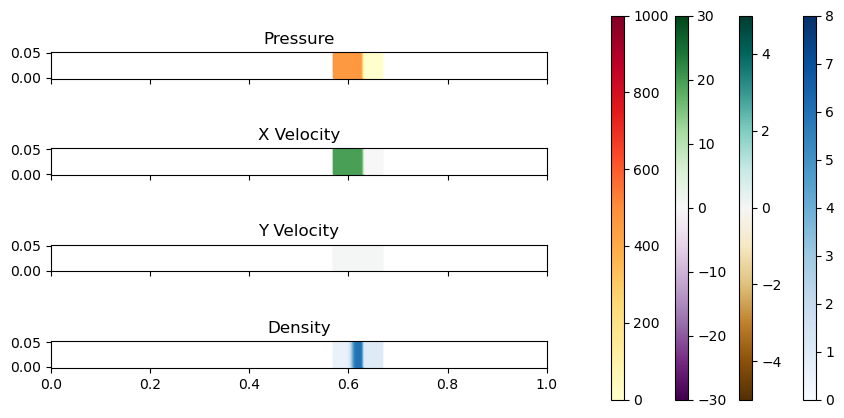

Finished step 190...
Finished step 191...
Finished step 192...
Finished step 193...
Finished step 194...


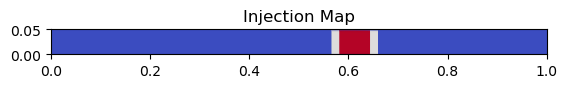

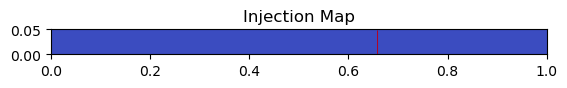

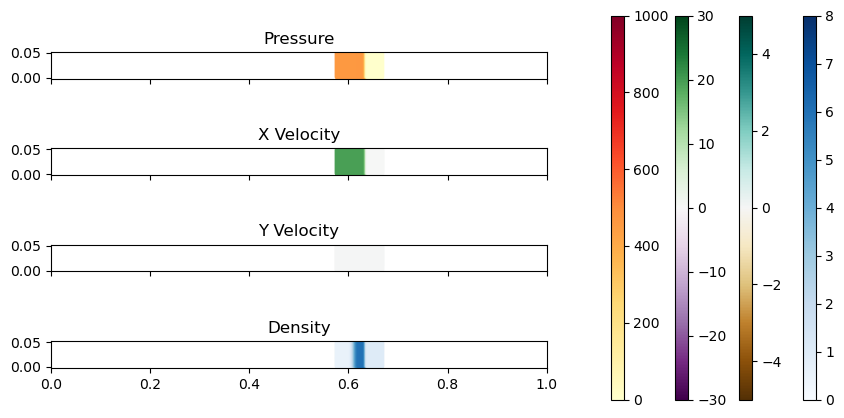

Finished step 195...
Finished step 196...
Finished step 197...
Finished step 198...
Finished step 199...


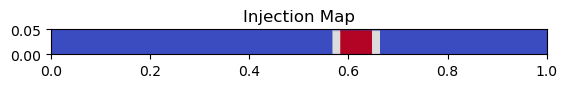

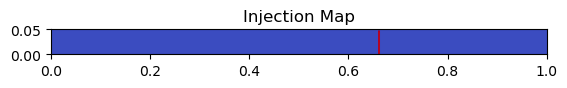

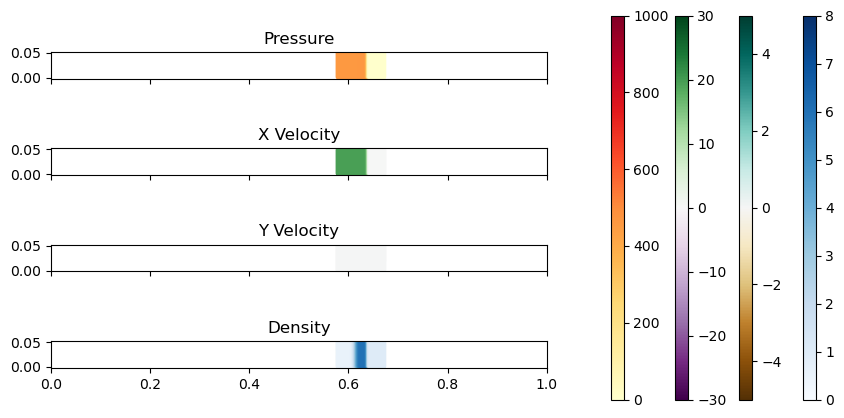

Finished step 200...
Finished step 201...
Finished step 202...
Finished step 203...
Finished step 204...


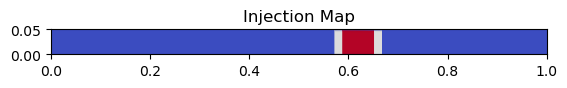

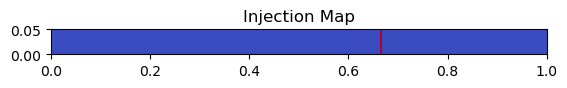

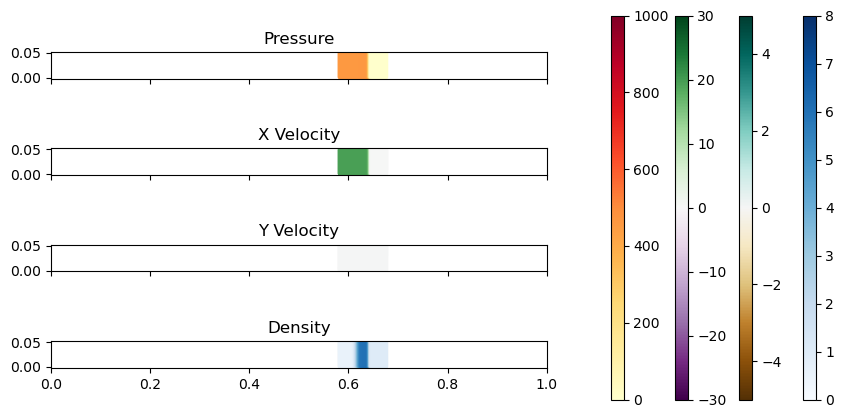

Finished step 205...
Finished step 206...
Finished step 207...
Finished step 208...
Finished step 209...


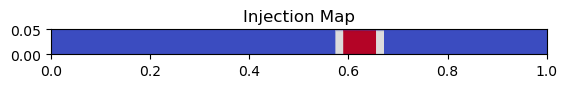

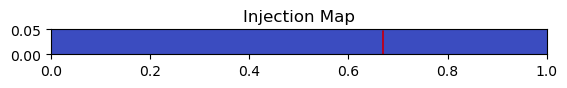

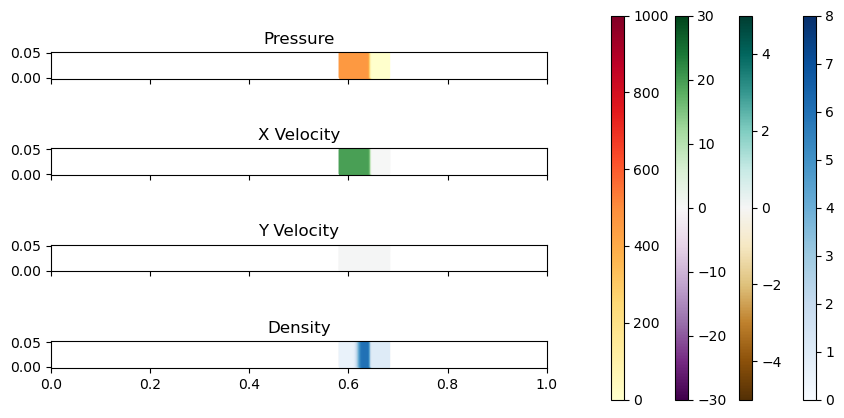

Finished step 210...
Finished step 211...
Finished step 212...
Finished step 213...
Finished step 214...


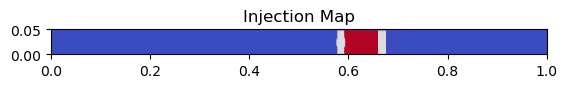

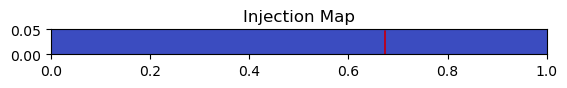

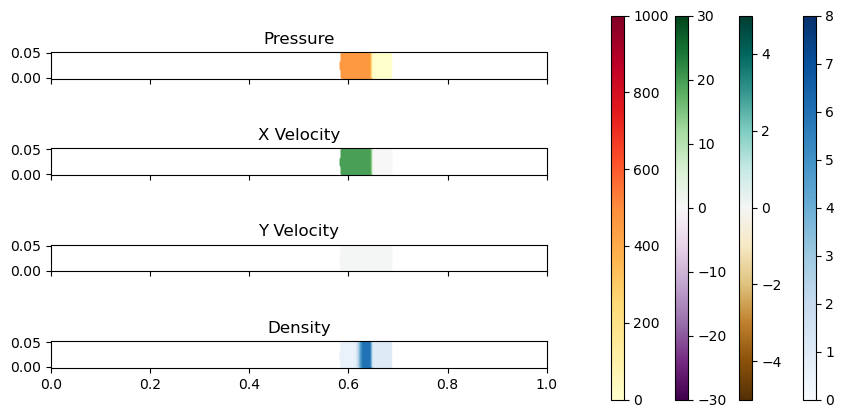

Finished step 215...
Finished step 216...
Finished step 217...
Finished step 218...
Finished step 219...


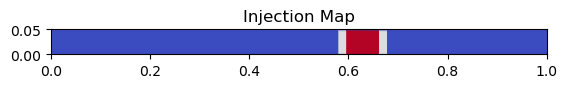

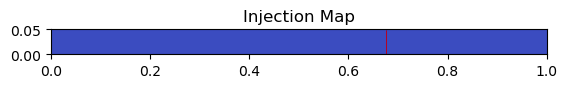

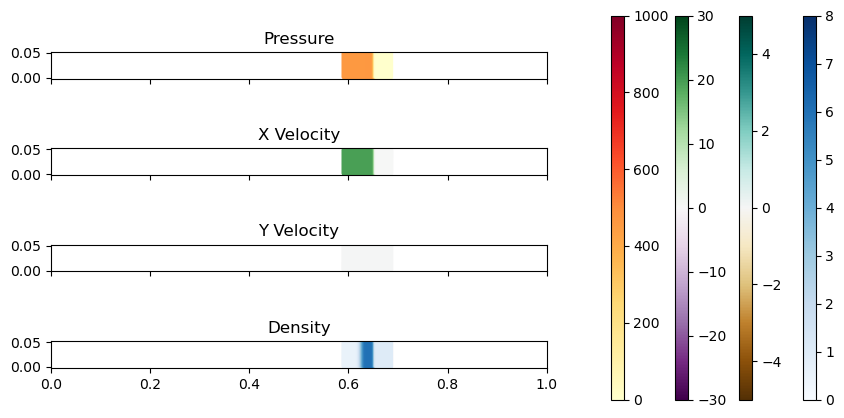

Finished step 220...
Finished step 221...
Finished step 222...
Finished step 223...
Finished step 224...


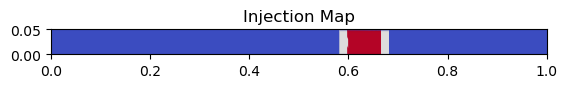

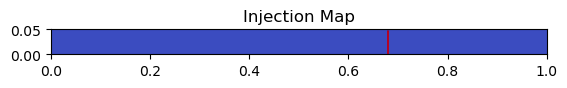

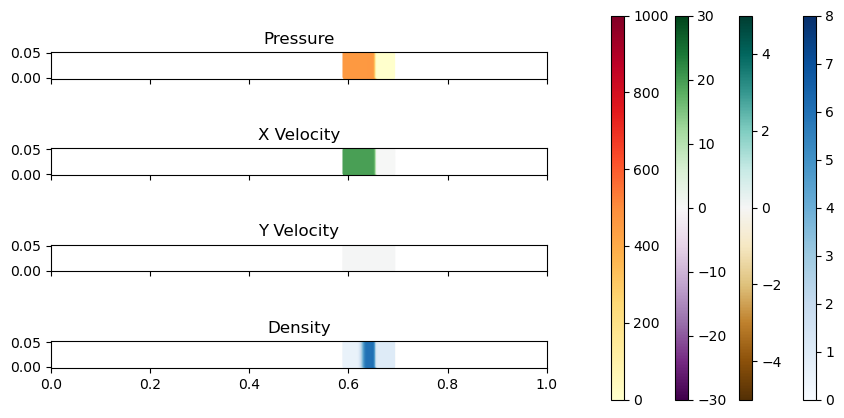

Finished step 225...
Finished step 226...
Finished step 227...
Finished step 228...
Finished step 229...


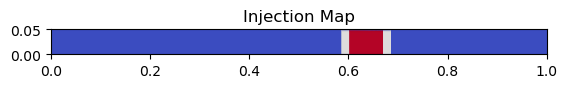

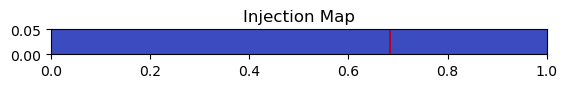

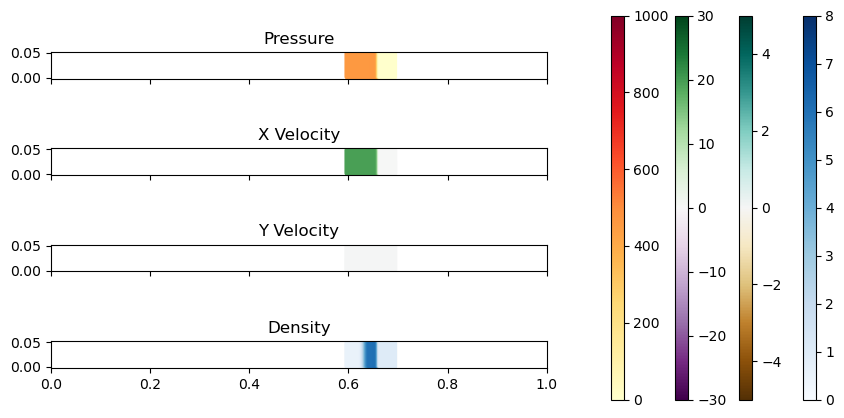

Finished step 230...
Finished step 231...
Finished step 232...
Finished step 233...
Finished step 234...


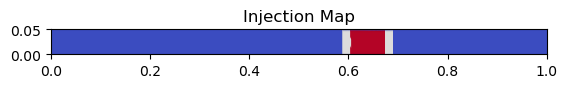

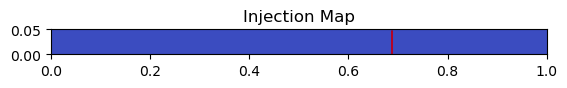

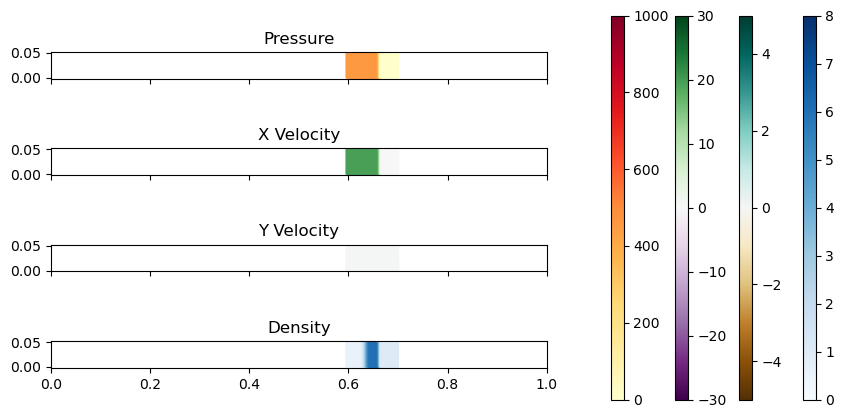

Finished step 235...
Finished step 236...
Finished step 237...
Finished step 238...
Finished step 239...


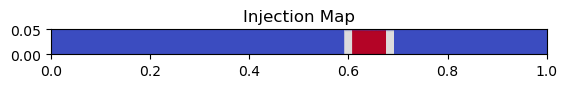

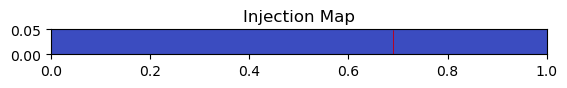

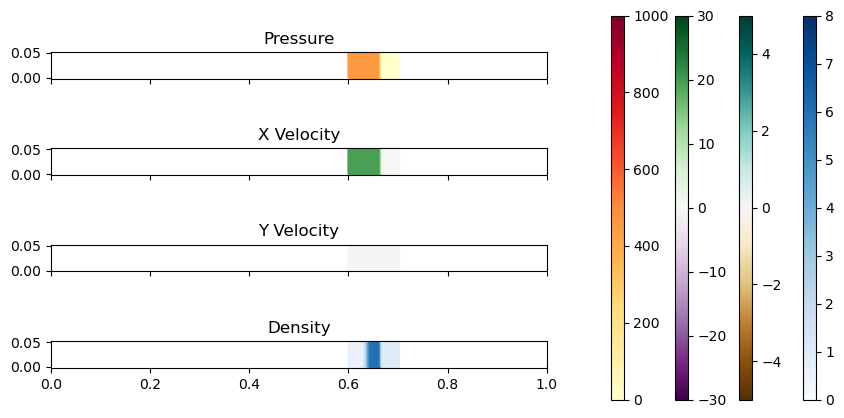

Finished step 240...
Finished step 241...
Finished step 242...
Finished step 243...
Finished step 244...


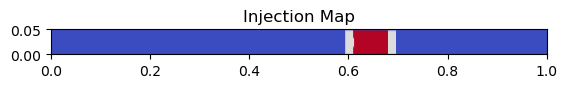

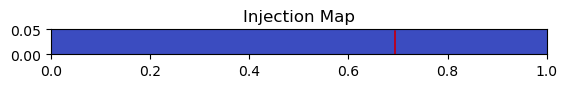

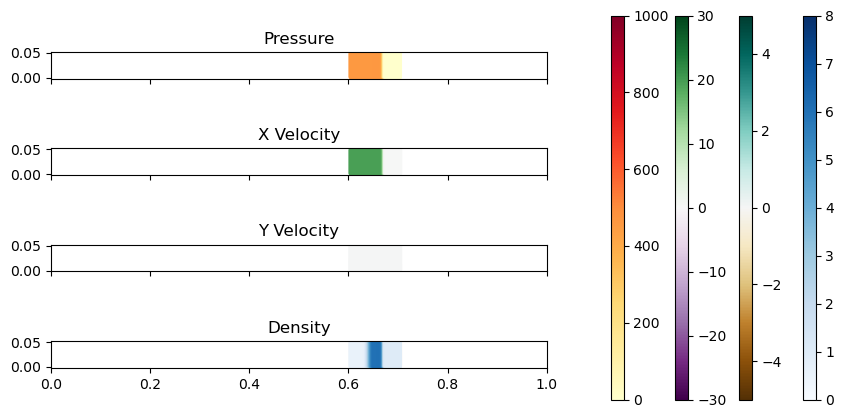

Finished step 245...
Finished step 246...
Finished step 247...
Finished step 248...
Finished step 249...


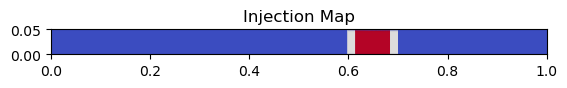

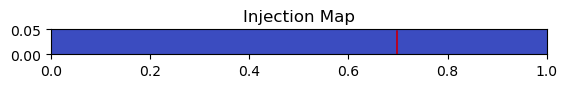

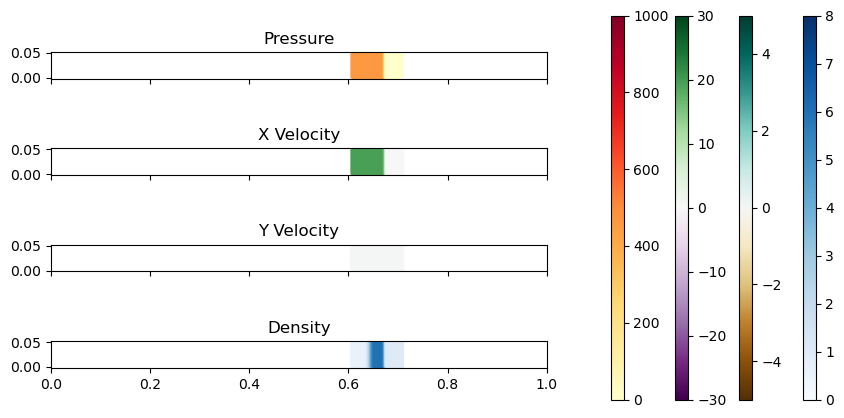

Finished step 250...
Finished step 251...
Finished step 252...
Finished step 253...
Finished step 254...


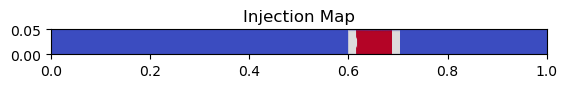

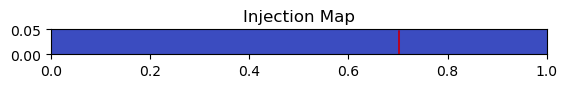

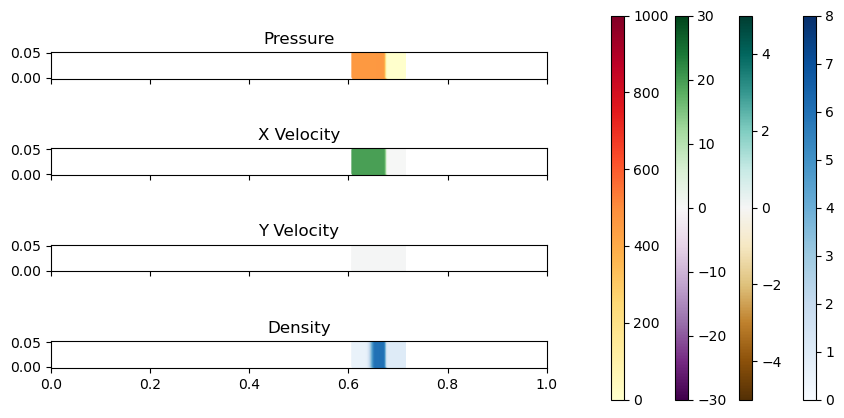

Finished step 255...
Finished step 256...
Finished step 257...
Finished step 258...
Finished step 259...


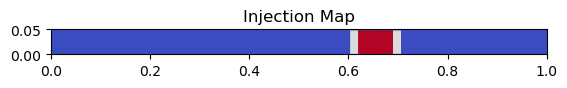

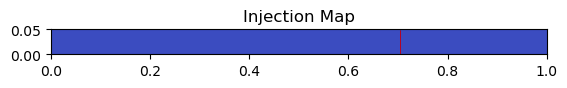

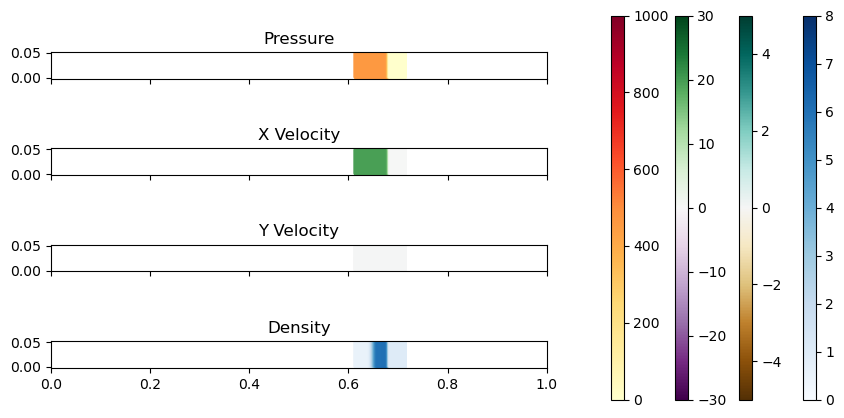

Finished step 260...
Finished step 261...
Finished step 262...
Finished step 263...
Finished step 264...


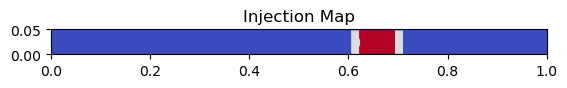

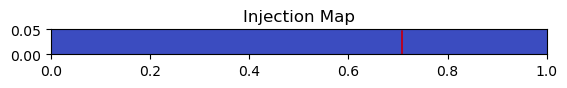

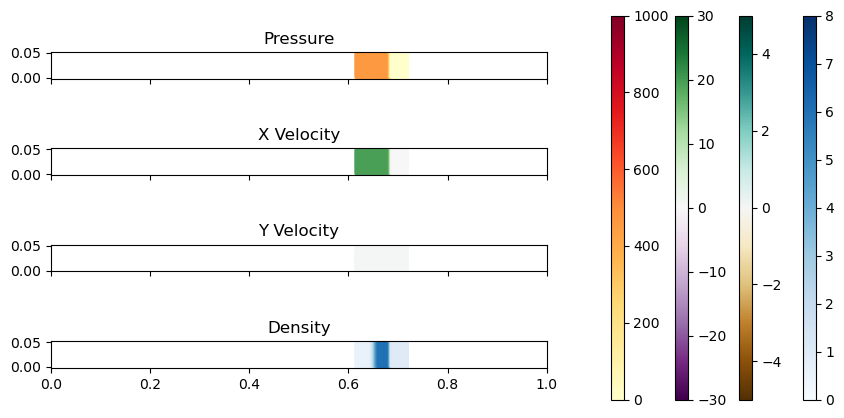

Finished step 265...
Finished step 266...
Finished step 267...
Finished step 268...
Finished step 269...


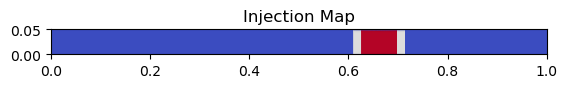

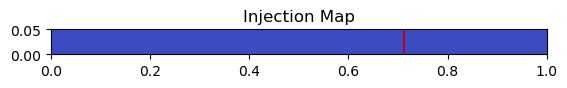

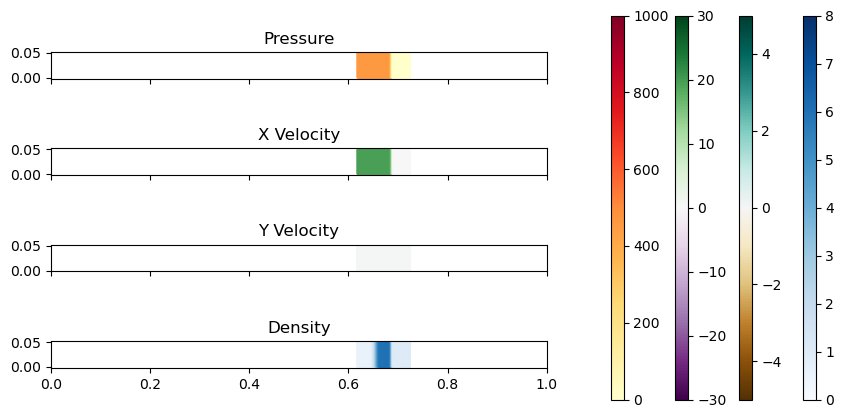

Finished step 270...
Finished step 271...
Finished step 272...
Finished step 273...
Finished step 274...


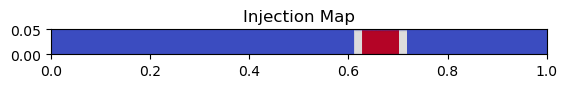

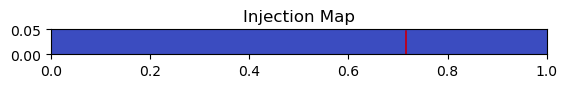

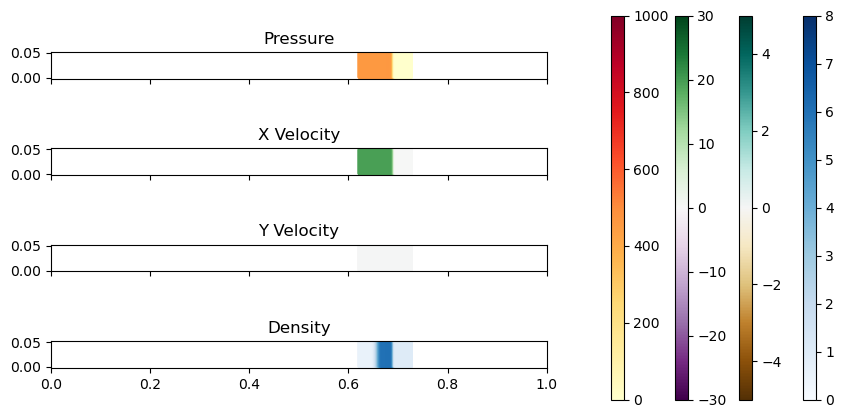

Finished step 275...
Finished step 276...
Finished step 277...
Finished step 278...
Finished step 279...


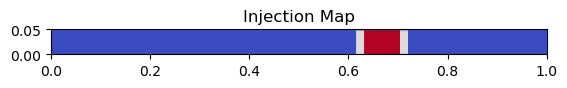

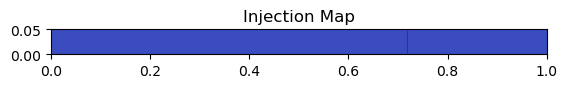

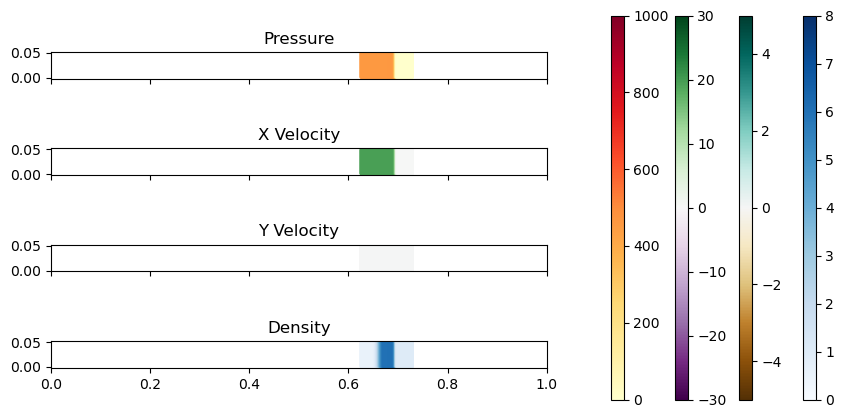

Finished step 280...
Finished step 281...
Finished step 282...
Finished step 283...
Finished step 284...


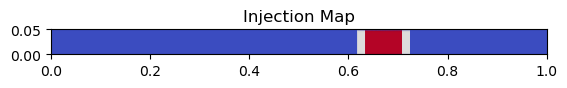

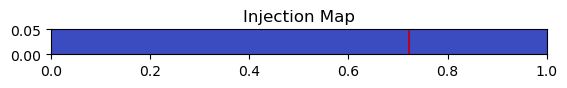

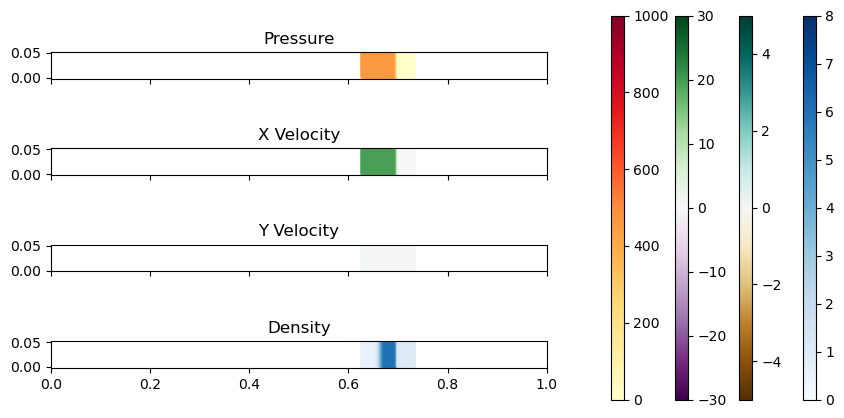

Finished step 285...
Finished step 286...
Finished step 287...
Finished step 288...
Finished step 289...


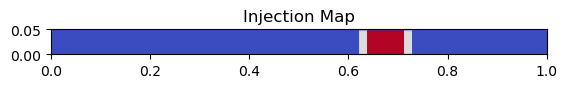

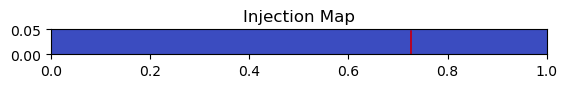

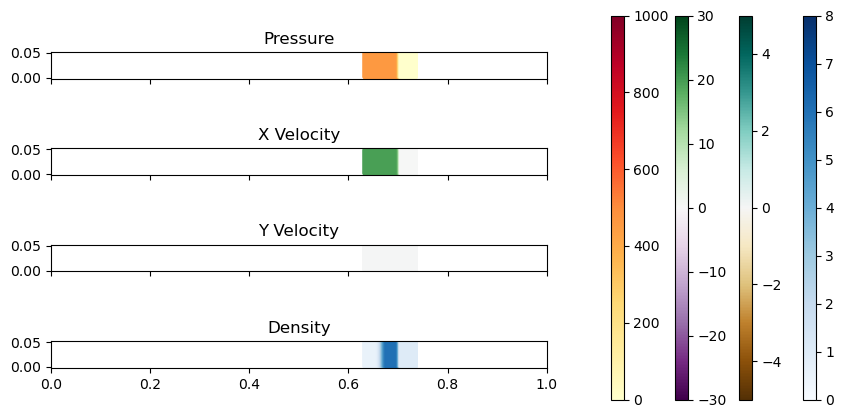

Finished step 290...
Finished step 291...
Finished step 292...
Finished step 293...
Finished step 294...


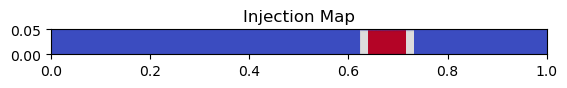

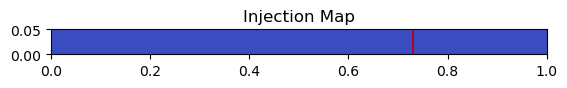

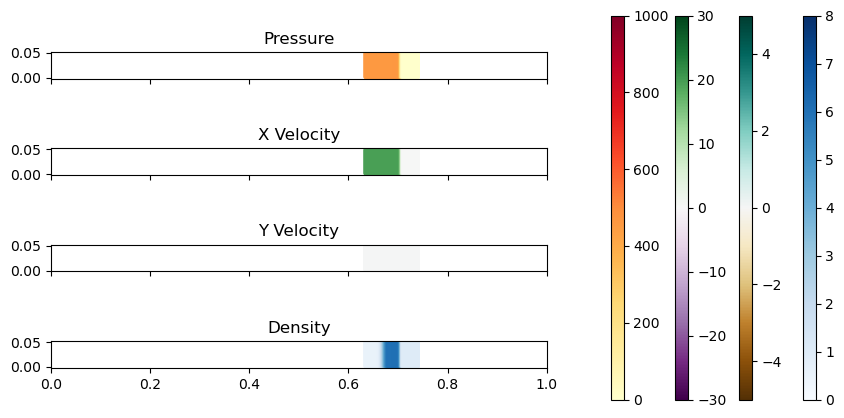

Finished step 295...
Finished step 296...
Finished step 297...
Finished step 298...
Finished step 299...


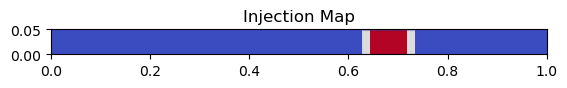

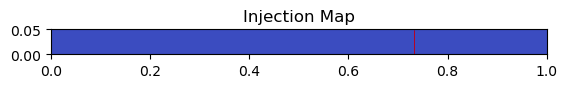

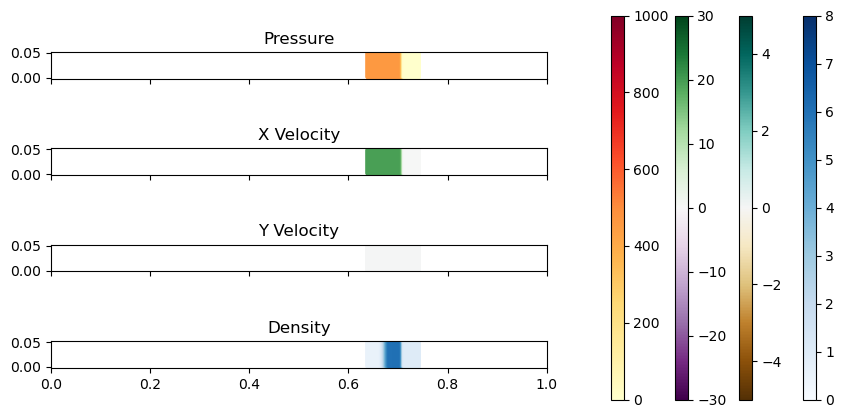

Finished step 300...
Finished step 301...
Finished step 302...
Finished step 303...
Finished step 304...


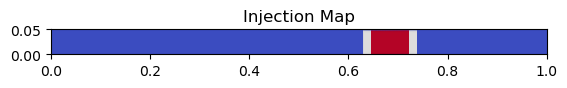

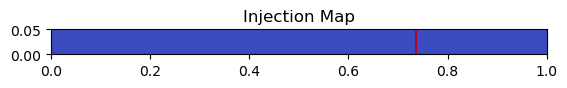

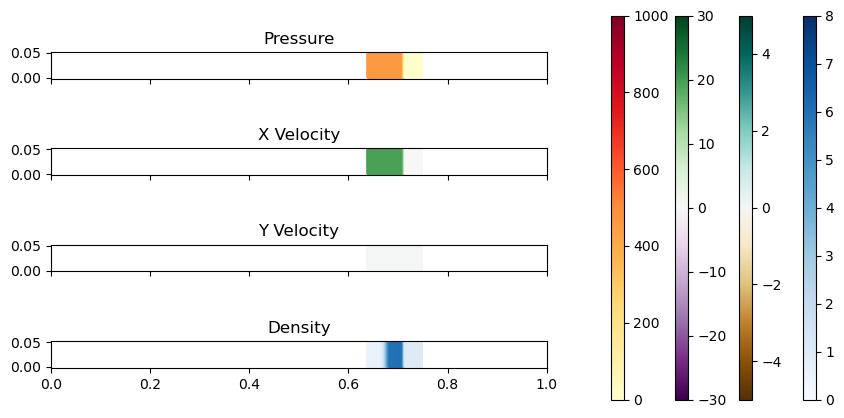

Finished step 305...
Finished step 306...
Finished step 307...
Finished step 308...
Finished step 309...


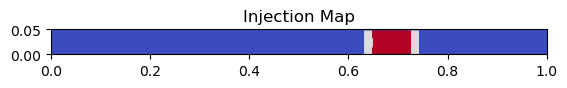

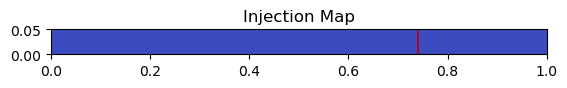

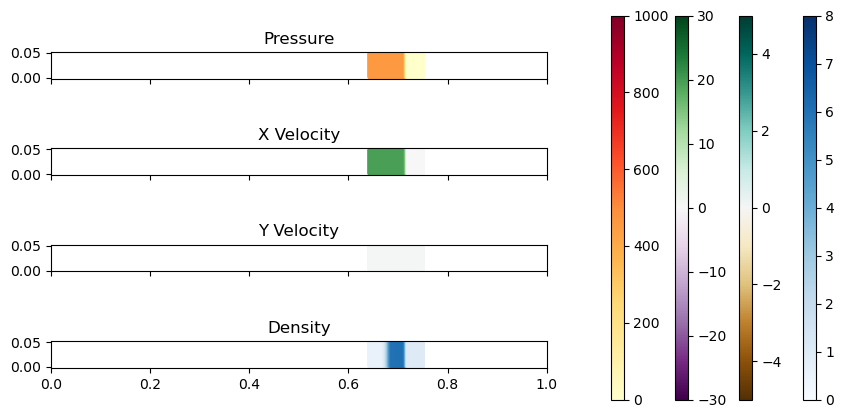

Finished step 310...
Finished step 311...
Finished step 312...
Finished step 313...
Finished step 314...


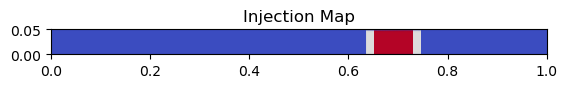

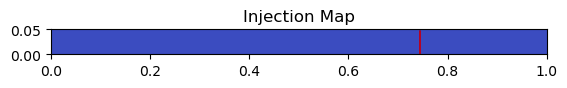

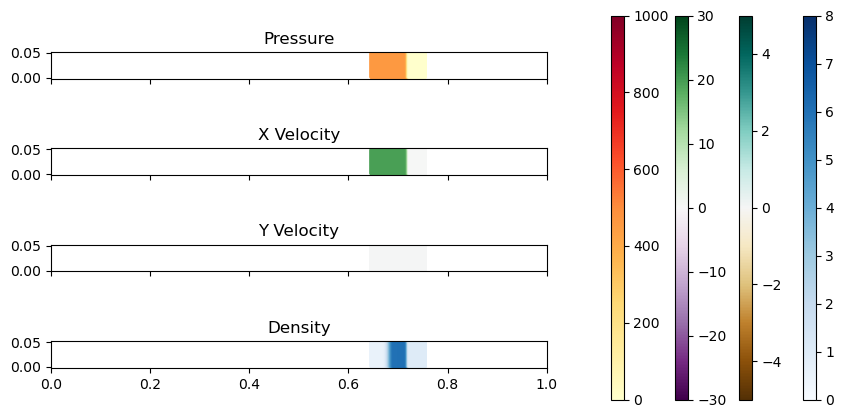

Finished step 315...
Finished step 316...
Finished step 317...
Finished step 318...
Finished step 319...


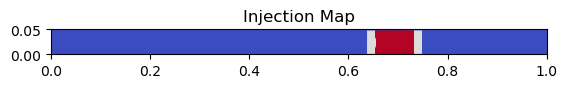

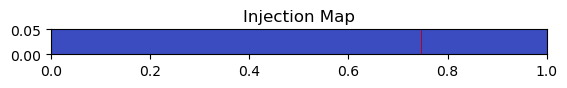

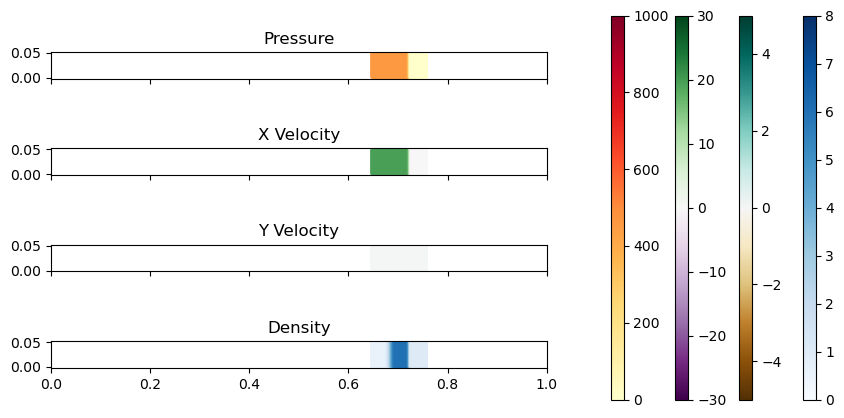

Finished step 320...
Finished step 321...
Finished step 322...
Finished step 323...
Finished step 324...


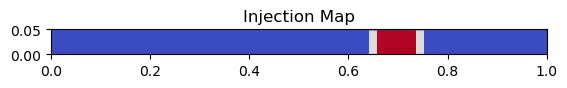

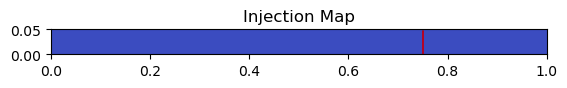

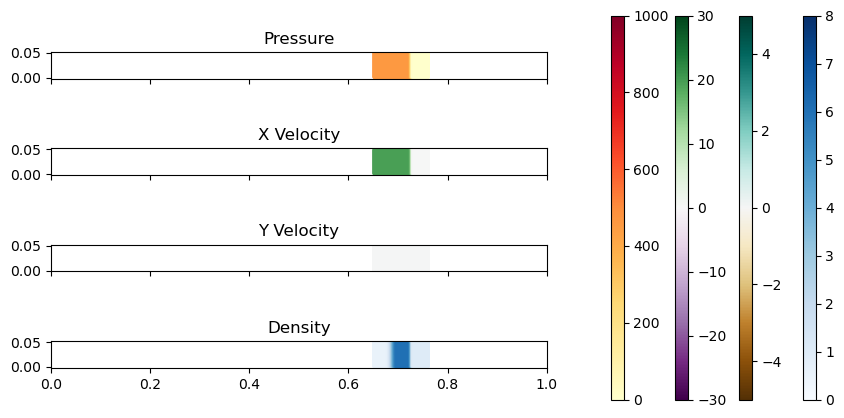

Finished step 325...
Finished step 326...
Finished step 327...
Finished step 328...
Finished step 329...


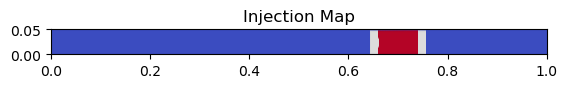

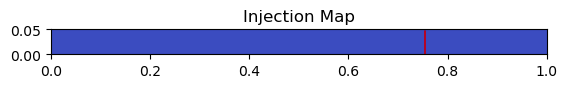

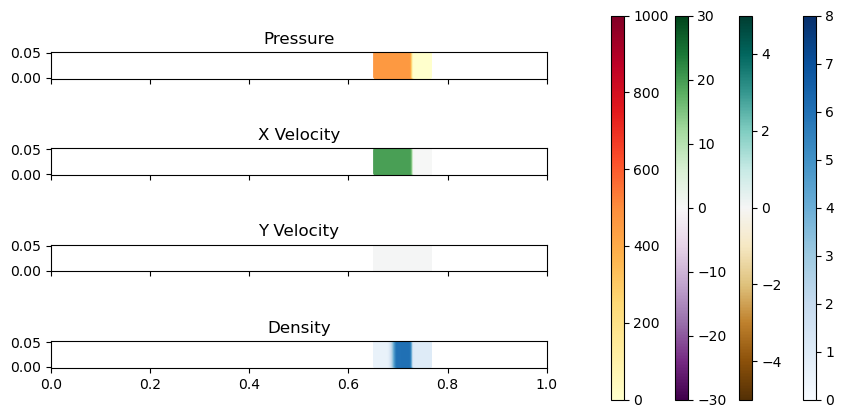

Finished step 330...
Finished step 331...
Finished step 332...
Finished step 333...
Finished step 334...


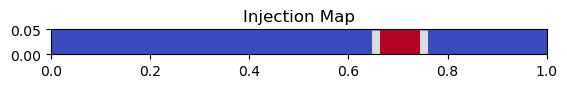

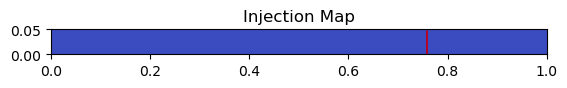

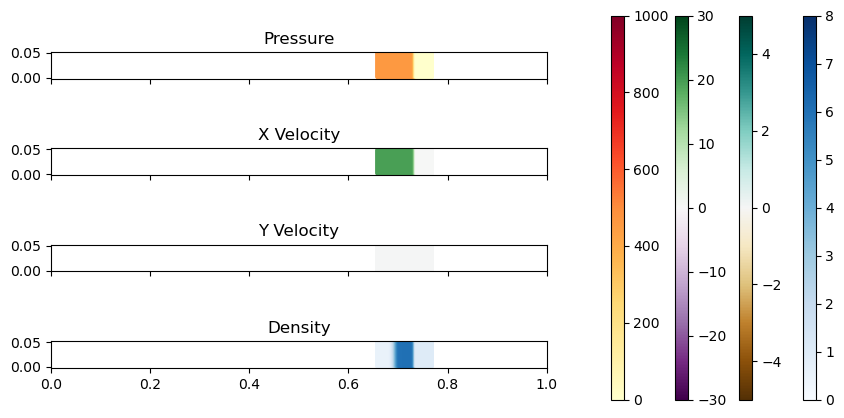

Finished step 335...
Finished step 336...
Finished step 337...
Finished step 338...
Finished step 339...


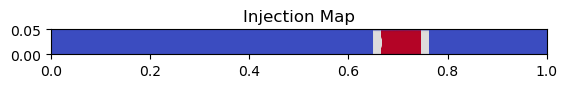

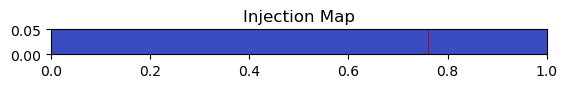

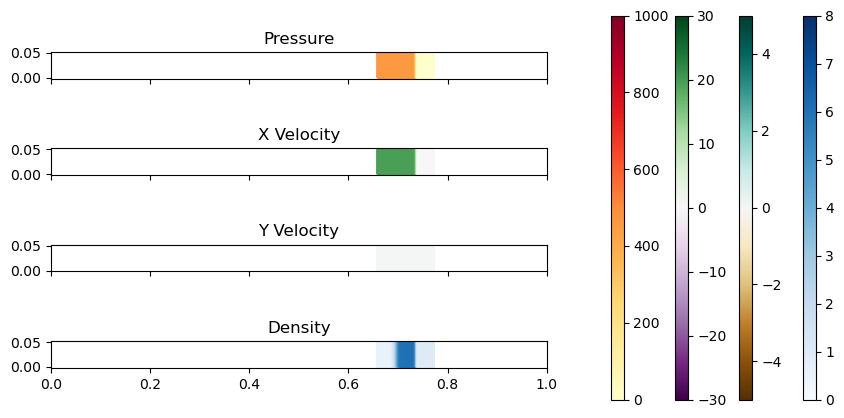

Finished step 340...
Finished step 341...
Finished step 342...
Finished step 343...
Finished step 344...


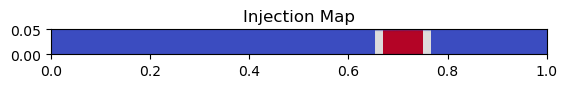

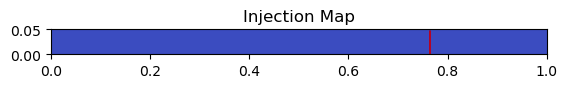

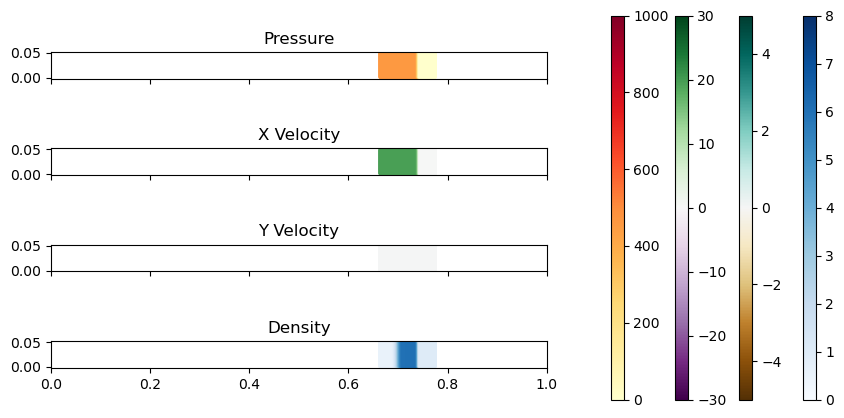

Finished step 345...
Finished step 346...
Finished step 347...
Finished step 348...
Finished step 349...


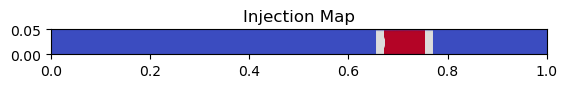

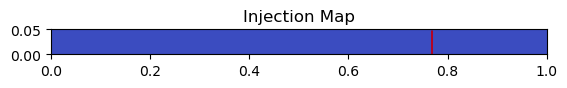

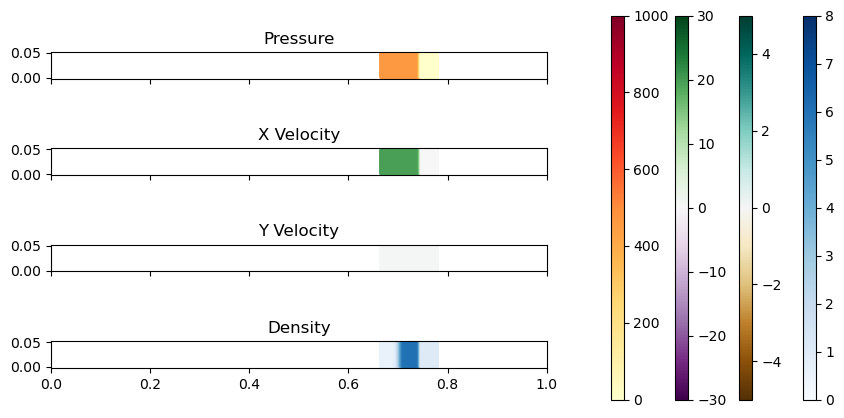

Finished step 350...
Finished step 351...
Finished step 352...
Finished step 353...
Finished step 354...


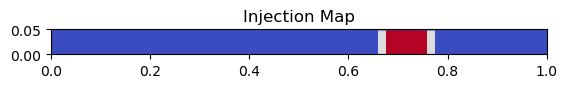

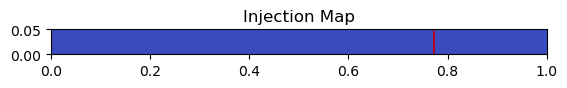

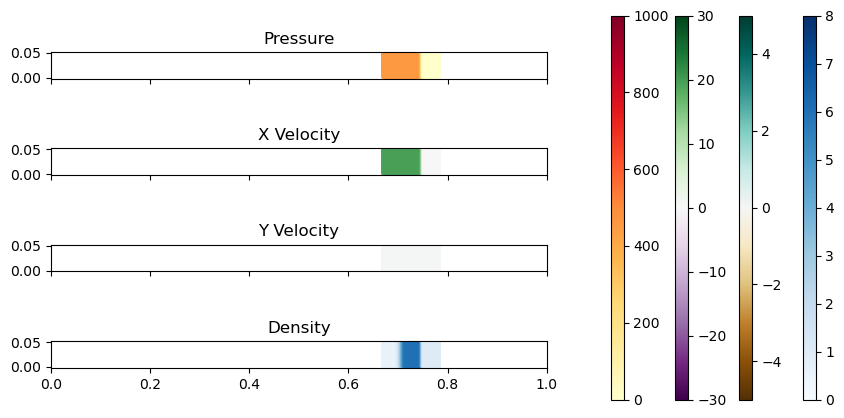

Finished step 355...
Finished step 356...
Finished step 357...
Finished step 358...
Finished step 359...


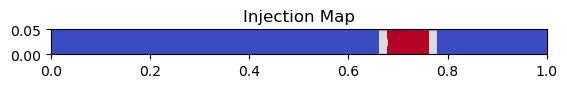

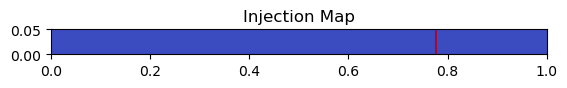

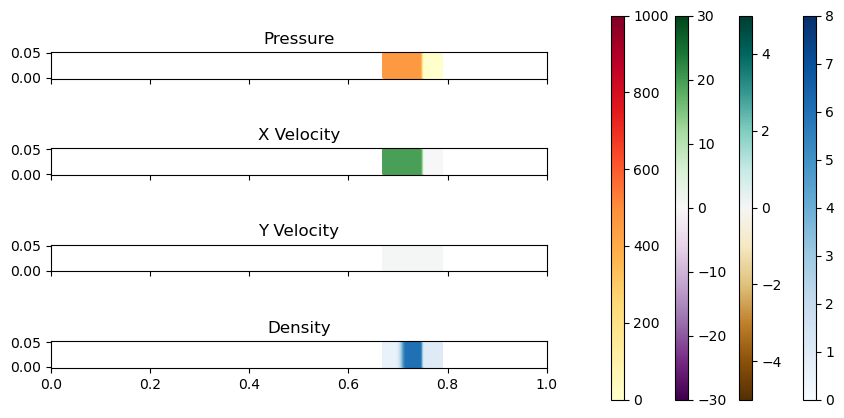

Finished step 360...
Finished step 361...
Finished step 362...
Finished step 363...
Finished step 364...


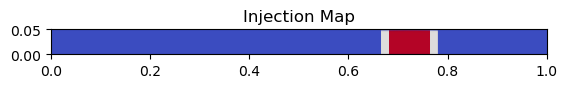

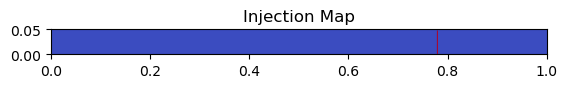

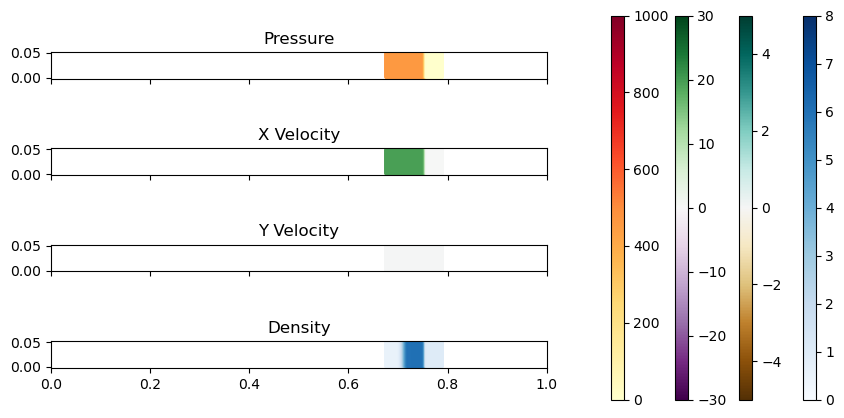

Finished step 365...
Finished step 366...
Finished step 367...
Finished step 368...
Finished step 369...


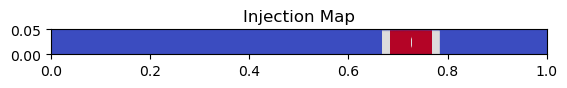

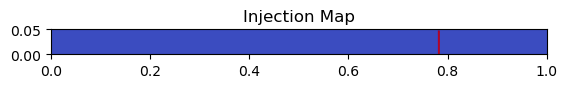

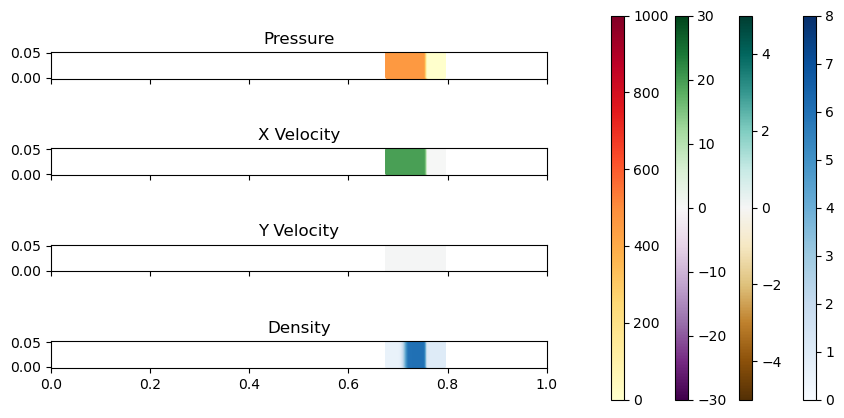

Finished step 370...
Finished step 371...
Finished step 372...
Finished step 373...
Finished step 374...


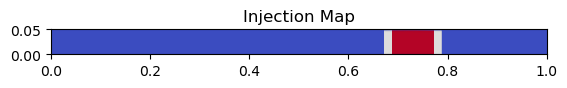

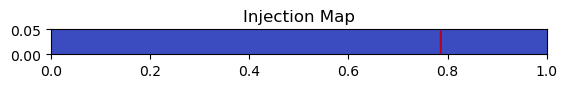

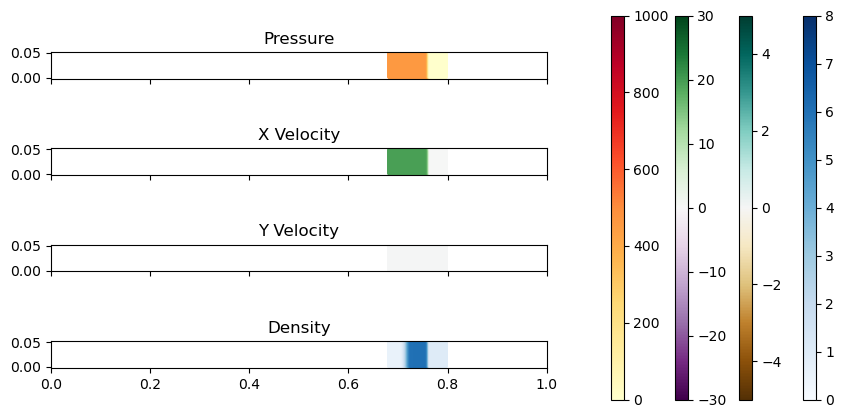

Finished step 375...
Finished step 376...
Finished step 377...
Finished step 378...
Finished step 379...


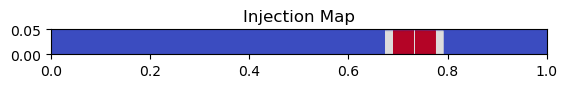

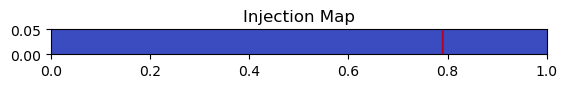

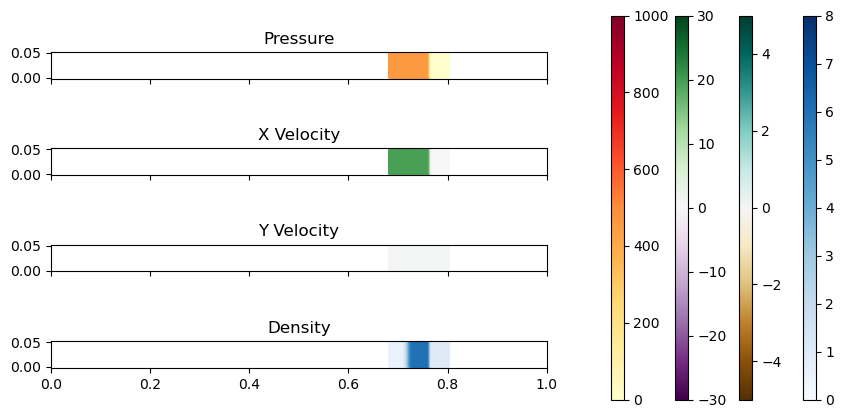

Finished step 380...
Finished step 381...
Finished step 382...
Finished step 383...
Finished step 384...


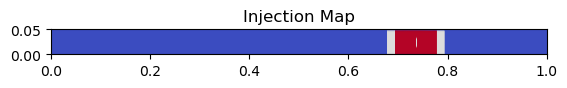

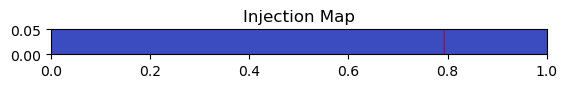

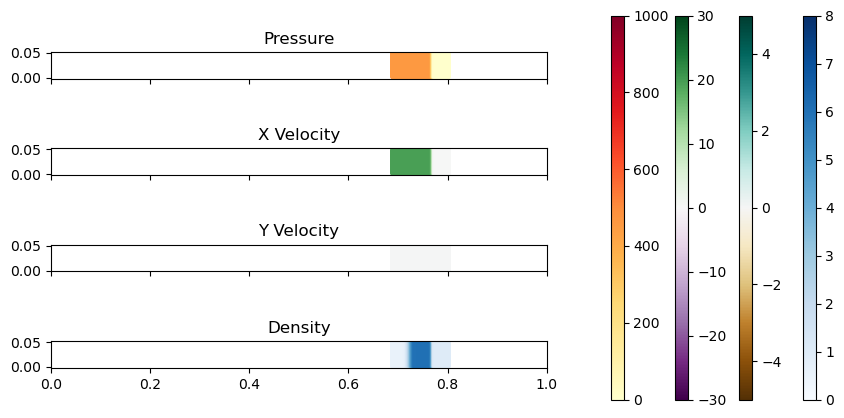

Finished step 385...
Finished step 386...
Finished step 387...
Finished step 388...
Finished step 389...


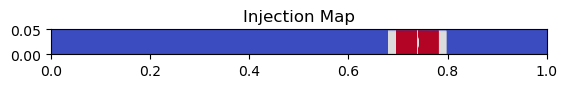

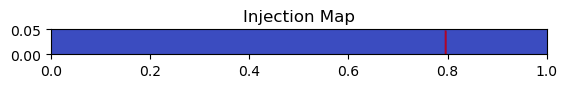

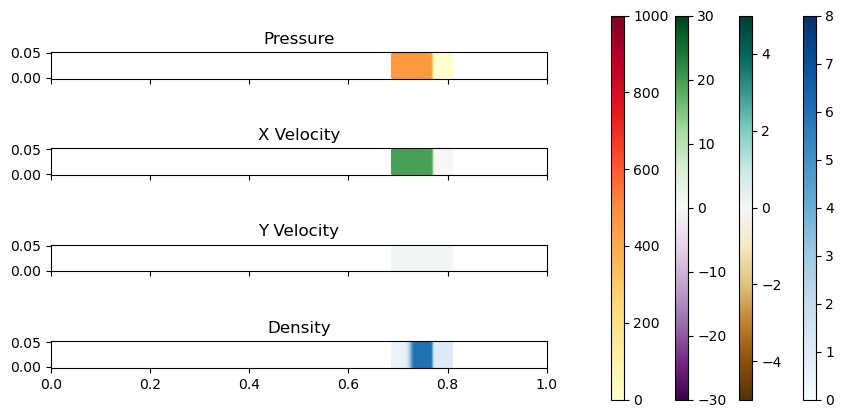

Finished step 390...
Finished step 391...
Finished step 392...
Finished step 393...
Finished step 394...


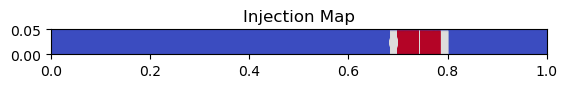

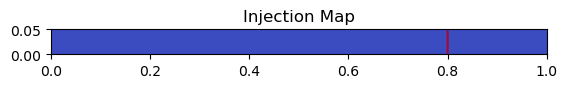

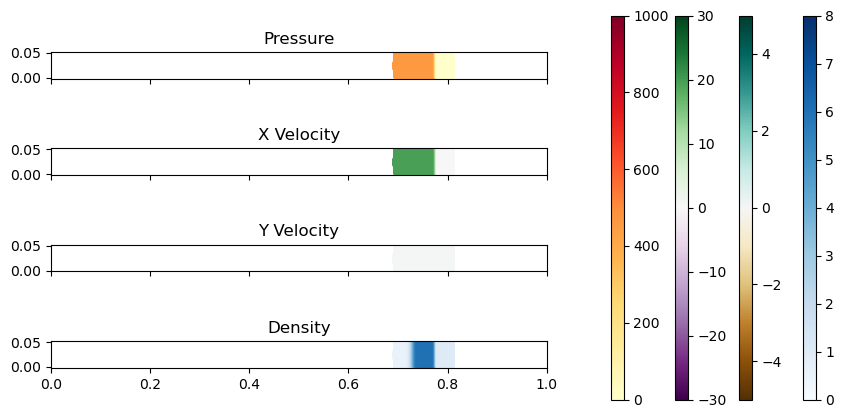

Finished step 395...
Finished step 396...
Finished step 397...
Finished step 398...
Finished step 399...


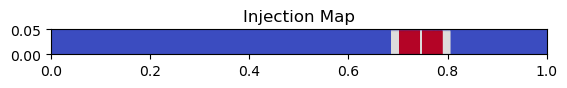

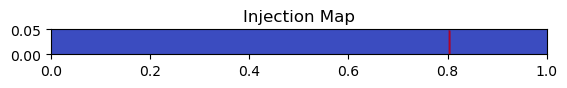

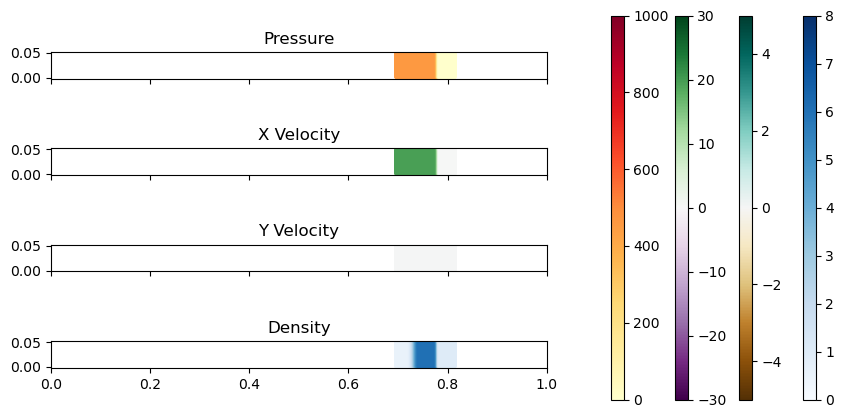

Finished step 400...
Finished step 401...
Finished step 402...
Finished step 403...
Finished step 404...


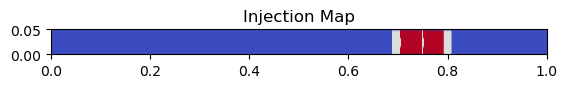

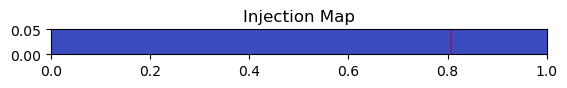

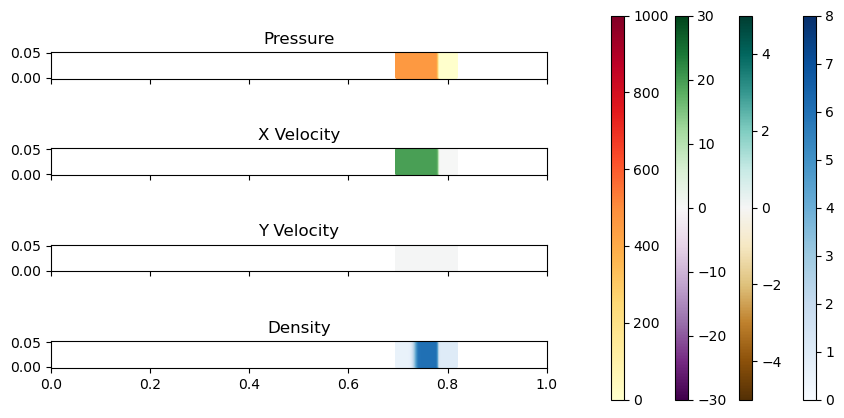

Finished step 405...
Finished step 406...
114.4924590587616


In [6]:
start = time.time()
#hybrid_sim.pyro_sim.run_sim()
count = 0
while (not hybrid_sim.pyro_sim.sim.finished()):
    hybrid_sim.pyro_sim.pyro_step()
    print("Finished step " + str(count) + "...")
    count += 1
    if ((count % 5)==0.):
        hybrid_sim.pyro_sim.primitive_update()
        hybrid_sim.pyro_sim.compute_gradients()
        hybrid_sim.pyro_sim.flag_gradients(threshold=[300,6000,6000,6000])
        #hybrid_sim.pyro_sim.plot_2D_vertical([0,1000,-30,30,-5,5,0,8])
        hybrid_sim.pyro_sim.pysph_zoning(8,8) # 4,4
        
        hybrid_sim.flag_pysph_particles()
        hybrid_sim.pysph_sim.remove_flagged_particles()
        
        hybrid_sim.extend_flag_to_particle_map()
        hybrid_sim.update_particle_map()
        hybrid_sim.inject_particles()
        
        hybrid_sim.pysph_sim.particle_sort()
        if (count < 6):
            print(count)
            hybrid_sim.pyro_to_pysph(mode='all')
        else:
            hybrid_sim.pyro_to_pysph(mode='all') # mode=None
        hybrid_sim.plot_2D_scatter_map(1)
        hybrid_sim.plot_2D_scatter_map(0)
        hybrid_sim.pysph_sim.plot_2D([0,1000,-30,30,-5,5,0,8])
    if (count > hybrid_sim.pyro_sim.sim.max_steps):
        break
end = time.time()
print(end-start)

In [ ]:
print(hybrid_sim.pysph_sim.particles[0].particle_type_id.min())

In [ ]:
#start = time.time()
hybrid_sim.pyro_sim.primitive_update()
hybrid_sim.pyro_sim.plot_2D_vertical([0,1000,-30,30,-5,5,0,8])
#end = time.time()
#print(end-start)

In [ ]:
#start = time.time()
hybrid_sim.pyro_sim.compute_gradients()
hybrid_sim.pyro_sim.plot_gradients_2D_vertical()
#end = time.time()
#print(end-start)

In [ ]:
hybrid_sim.flag_pysph_particles()

In [ ]:
hybrid_sim.pysph_sim.plot_type_id()

In [ ]:
start = time.time()
hybrid_sim.pysph_sim.remove_flagged_particles()
end = time.time()
print(end-start)
# first func (s): 0.0361, 0.0144, 0.147, 0.0146, 0.0142
# second func (s): 0.0140, 0.147, 0.0144, 0.0150, 0.0148

In [ ]:
#pprint(hybrid_sim.pysph_sim.particles[0].get_property_arrays())
#pprint(vars(hybrid_sim.pyro_sim.sim.cc_data))

<h3> Embedded PySPH Testing

In [ ]:
# For testing Pyro first
hybrid_sim.pysph_sim.particle_sort()
hybrid_sim.pyro_to_pysph(mode='all') # mode='all'

In [ ]:
start = time.time()
hybrid_sim.pysph_sim.step(67) # 667
end = time.time()
print("time: " + str(end-start))

In [ ]:
hybrid_sim.pysph_sim.plot_2D([0,1000,-30,30,-5,5,0,8])

In [ ]:
a = [0,0,0]
b = [1,1,1]
print(not(a))
print(not(b))